In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from collections import Counter
from sklearn.base import clone
from sklearn.cluster import MeanShift, estimate_bandwidth

from datetime import datetime
import matplotlib.pyplot as plt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# # Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes

# from pandas_profiling import ProfileReport

In [120]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df.set_index('CustID', inplace=True)

In [121]:
df.head(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [122]:
df.shape

(10296, 13)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [124]:
non_metric_features = ["EducDeg", "Children", 'GeoLivArea']
metric_features=df.columns.drop(non_metric_features).to_list()

In [125]:
df_info = pd.DataFrame(columns=["column", "NaN", "NaN %"])
for index, value in df.isna().sum().iteritems():
    df_temp = pd.DataFrame({"column" : index, "NaN" : [value], "NaN %" : round(value*100 /len(df), 2)})
    df_info = pd.concat([df_info, df_temp], ignore_index=True)
    df_info.sort_values(by="NaN", ascending=False, inplace=True)

print(df_info)

           column  NaN  NaN %
0        PremLife  104   1.01
12       PremWork   86   0.84
1      PremHealth   43   0.42
2        MonthSal   36   0.35
3       PremMotor   34   0.33
4    FirstPolYear   30   0.29
5        Children   21   0.20
6       BirthYear   17   0.17
7         EducDeg   17   0.17
8      GeoLivArea    1   0.01
9      CustMonVal    0   0.00
10     ClaimsRate    0   0.00
11  PremHousehold    0   0.00


C:\Users\henri\AppData\Local\Temp\ipykernel_1860\1500608793.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df.isna().sum().iteritems():


### %%%% explicar que como nenhuma coluna tem mais de 3% de Nans, não eliminamos os nans, vamos imputar

In [126]:
#Check duplicates
df.duplicated().sum()

3

In [127]:
df.drop_duplicates(inplace=True)

In [128]:
#Check duplicates
df.duplicated().sum()

0

# Fill Nans
### This data doesn't have a lot of missing values, but we will fill them with 4 different approaches and then test it when doing clusters
#### For each approach we are going to plot a range of data (using the metric with more missing values VS another metric), so that it is possible to identify the missing values ​​filled in. Since if we showed all the data, it would be impossible to see them graphically
#### All filled missing values are going to be plotted in red color

### - Using mode for both metric and non metric:

In [129]:
# # Mode Imputation

# df_mode = df.copy()
# mode_imputer = SimpleImputer(strategy='most_frequent')
# df_mode[metric_features] = mode_imputer.fit_transform(df_mode[metric_features].values)
# df_mode[non_metric_features] = mode_imputer.fit_transform(df_mode[non_metric_features].values)

# # Scatter plot

# fig = plt.Figure()
# null_values = df['PremLife'].isnull()
# fig = df_mode[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mode Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using mean for metric and mode for non metric:

In [130]:
# # Mean Imputation

# df_mean = df.copy()
# mean_imputer = SimpleImputer(strategy='mean')
# df_mean[metric_features] = mean_imputer.fit_transform(df_mean[metric_features].values)
# df_mean[non_metric_features] = mode_imputer.fit_transform(df_mean[non_metric_features].values)


# # Scatter plot

# fig = plt.Figure()
# null_values = df['PremLife'].isnull()
# fig = df_mean[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mean Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)



### - Using KNN Imputer for both metric and non metric:

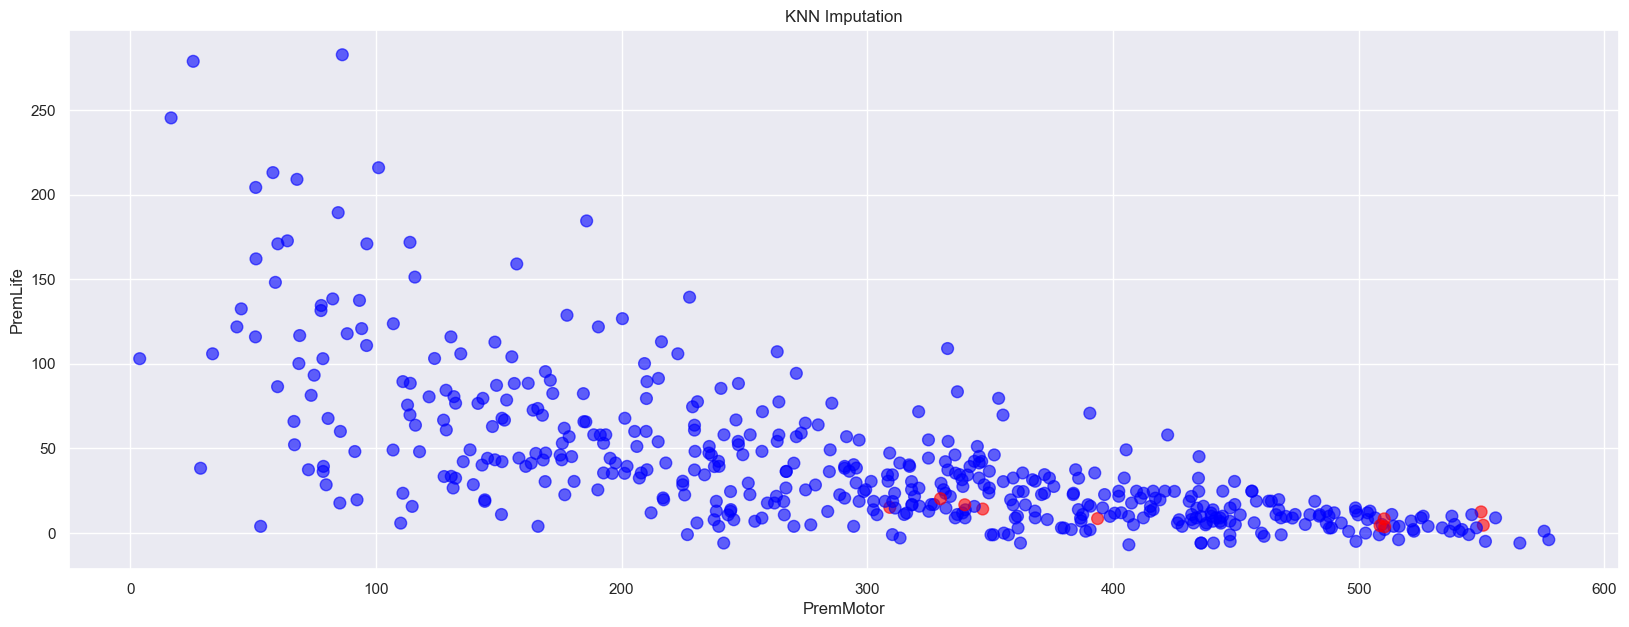

In [131]:
df_kmeans=df.copy()

le=LabelEncoder()

imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_kmeans[metric_features] = imputer.fit_transform(df_kmeans[metric_features])

dict_educdeg = {b'3 - BSc/MSc' : 3,  b'2 - High School' : 2, b'1 - Basic': 1 , b'4 - PhD': 4}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)

# df_kmeans['EducDeg']=df_kmeans['EducDeg'].astype(int)

df_kmeans[non_metric_features] = imputer.fit_transform(df_kmeans[non_metric_features])

#round new values to one of the labels
df_kmeans['EducDeg']=df_kmeans['EducDeg'].round(0)
df_kmeans['Children']=df_kmeans['Children'].round(0)
df_kmeans['GeoLivArea']=df_kmeans['GeoLivArea'].round(0)


dict_educdeg = {3 : b'3 - BSc/MSc', 2: b'2 - High School',1 :  b'1 - Basic' , 4 : b'4 - PhD'}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_kmeans[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='KNN Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using linear interpolation for both metric and non metric:

In [132]:
# df_interpolation=df.copy()
# # Imputing with linear interpolation
# linear_interpolation = df_interpolation.interpolate(method='linear')

# # Plot imputed data

# linear_interpolation['PremLife'][4020:4502].plot(color='red', marker='o', linestyle='dotted')
# df_interpolation['PremLife'][4020:4502].plot(title='PremLife', marker='o', figsize=(35,7))

In [133]:
df_filled=df_kmeans.copy()

In [134]:
#convert some variables to int
df_filled = df_filled.astype({'FirstPolYear': int, 'BirthYear': int, 'MonthSal': int , 'GeoLivArea': int, 'Children': int})
#convert index to int
df_filled.index = df_filled.index.astype(int)

In [135]:
df_filled.sample(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
7837,1995,1964,b'2 - High School',3143,4,1,182.15,0.78,241.60,402.85,166.81,47.23,81.68
2276,1992,1974,b'3 - BSc/MSc',2339,2,1,73.23,0.86,378.85,123.90,184.70,7.89,17.78
3219,1993,1940,b'1 - Basic',4055,2,0,454.88,0.53,232.60,529.00,119.80,49.12,82.68
1504,1995,1986,b'2 - High School',1988,2,1,125.35,0.81,306.39,187.80,166.03,78.57,37.45
5569,1983,1987,b'3 - BSc/MSc',1747,1,1,130.36,0.77,316.17,103.35,205.04,11.89,40.12


In [136]:
#Check if Nans were all filled
df_filled.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [137]:
# print columns with Nans
nans_index = df.isna().any(axis=1)
df[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22.0,1977.0,1958.0,b'2 - High School',NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
69.0,1983.0,1977.0,b'2 - High School',1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139.0,1979.0,1976.0,b'2 - High School',2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
144.0,1996.0,1990.0,b'3 - BSc/MSc',NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
185.0,1993.0,1984.0,b'2 - High School',2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011.0,NaN,1947.0,b'2 - High School',3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10058.0,1983.0,1980.0,b'2 - High School',1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10143.0,1986.0,1985.0,b'3 - BSc/MSc',1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78


In [138]:
#print the same columns with Nans filled
df_filled[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22,1977,1958,b'2 - High School',2541,3,1,111.37,0.80,407.520,111.70,100.130,24.670,30.340
69,1983,1977,b'2 - High School',1399,4,1,476.65,0.33,330.730,186.70,211.150,33.784,15.780
139,1979,1976,b'2 - High School',2538,2,1,149.59,0.69,194.260,305.60,226.598,37.340,17.670
144,1996,1990,b'3 - BSc/MSc',1721,4,1,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
185,1993,1984,b'2 - High School',2419,4,1,-62.23,1.07,264.428,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011,1990,1947,b'2 - High School',3959,2,1,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10058,1983,1980,b'2 - High School',1569,4,1,222.60,0.55,235.600,211.15,247.602,32.340,68.790
10143,1986,1985,b'3 - BSc/MSc',1652,3,1,55.67,0.88,257.050,94.45,308.390,23.338,13.780


In [139]:
#copy to df
df=df_filled.copy()

In [140]:
#convert birth year to age
df['Age'] = 2016-df['BirthYear']
df.drop(columns='BirthYear', inplace=True)

#remove from metric_features list
metric_features.remove('BirthYear')

#add age to metric_features list
metric_features.append('Age')

In [141]:
# print of unique values to check coherence
for col in df[non_metric_features]:
    print('\033[1;3mUnique values of "' + col + '"\033[0m ')
    print(df[col].unique())
    print('\n')

Unique values of "EducDeg" 
[b'2 - High School' b'1 - Basic' b'3 - BSc/MSc' b'4 - PhD']


Unique values of "Children" 
[1 0]


Unique values of "GeoLivArea" 
[1 4 3 2]




<AxesSubplot: xlabel='GeoLivArea', ylabel='count'>

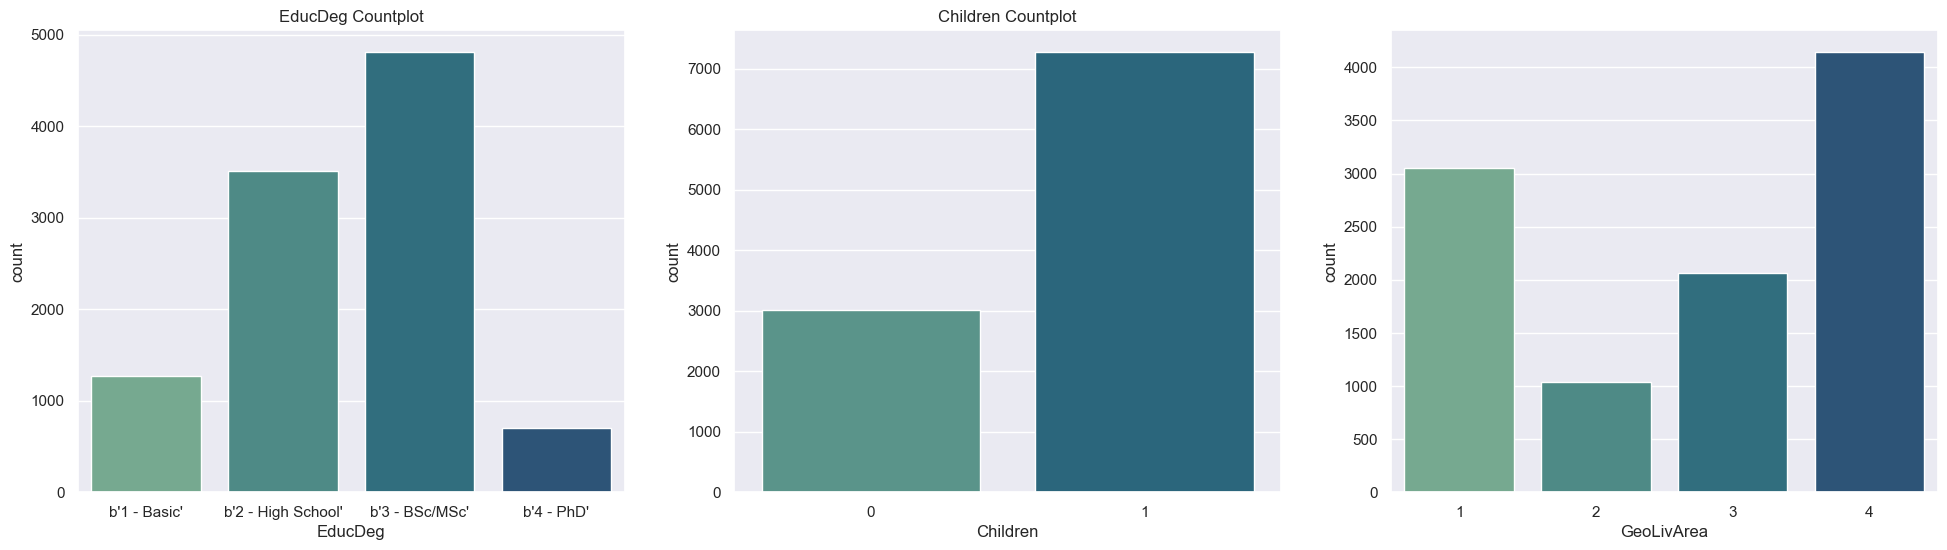

In [142]:
fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].title.set_text('EducDeg Countplot')
ax[1].title.set_text('Children Countplot')
sns.countplot(data=df, x="EducDeg", ax=ax[0], palette='crest', order=df.EducDeg.value_counts().index.sort_values(), dodge=False)
sns.countplot(data=df, x="Children", ax=ax[1], palette='crest',  dodge=False)
sns.countplot(data=df, x="GeoLivArea", ax=ax[2], palette='crest',  dodge=False)


In [143]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FirstPolYear,10293.0,NaN,NaN,NaN,1991.049062,510.596931,1974.0,1980.0,1986.0,1992.0,53784.0
EducDeg,10293,4,b'3 - BSc/MSc',4808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10293.0,NaN,NaN,NaN,2506.40921,1156.183192,333.0,1706.0,2501.0,3290.0,55215.0
GeoLivArea,10293.0,NaN,NaN,NaN,2.709414,1.266241,1.0,1.0,3.0,4.0,4.0
Children,10293.0,NaN,NaN,NaN,0.706597,0.455344,0.0,0.0,1.0,1.0,1.0
CustMonVal,10293.0,NaN,NaN,NaN,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89
ClaimsRate,10293.0,NaN,NaN,NaN,0.742728,2.917385,0.0,0.39,0.72,0.98,256.2
PremMotor,10293.0,NaN,NaN,NaN,300.702459,211.67798,-4.11,191.26,299.28,408.3,11604.42
PremHousehold,10293.0,NaN,NaN,NaN,210.419863,352.635041,-75.0,49.45,132.8,290.05,25048.8
PremHealth,10293.0,NaN,NaN,NaN,171.596339,295.845039,-2.11,111.91,162.92,219.04,28272.0


### Analysis before outliers

In [144]:
def box_plot_all_vars(data):
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(25, 20))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        bxplot = sns.boxplot(x=data[feat], ax=ax, color='chartreuse', fliersize=8)
        bxplot.set_xlabel(fontsize=16, xlabel=feat)

    
        
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title, size=30)

    plt.show()

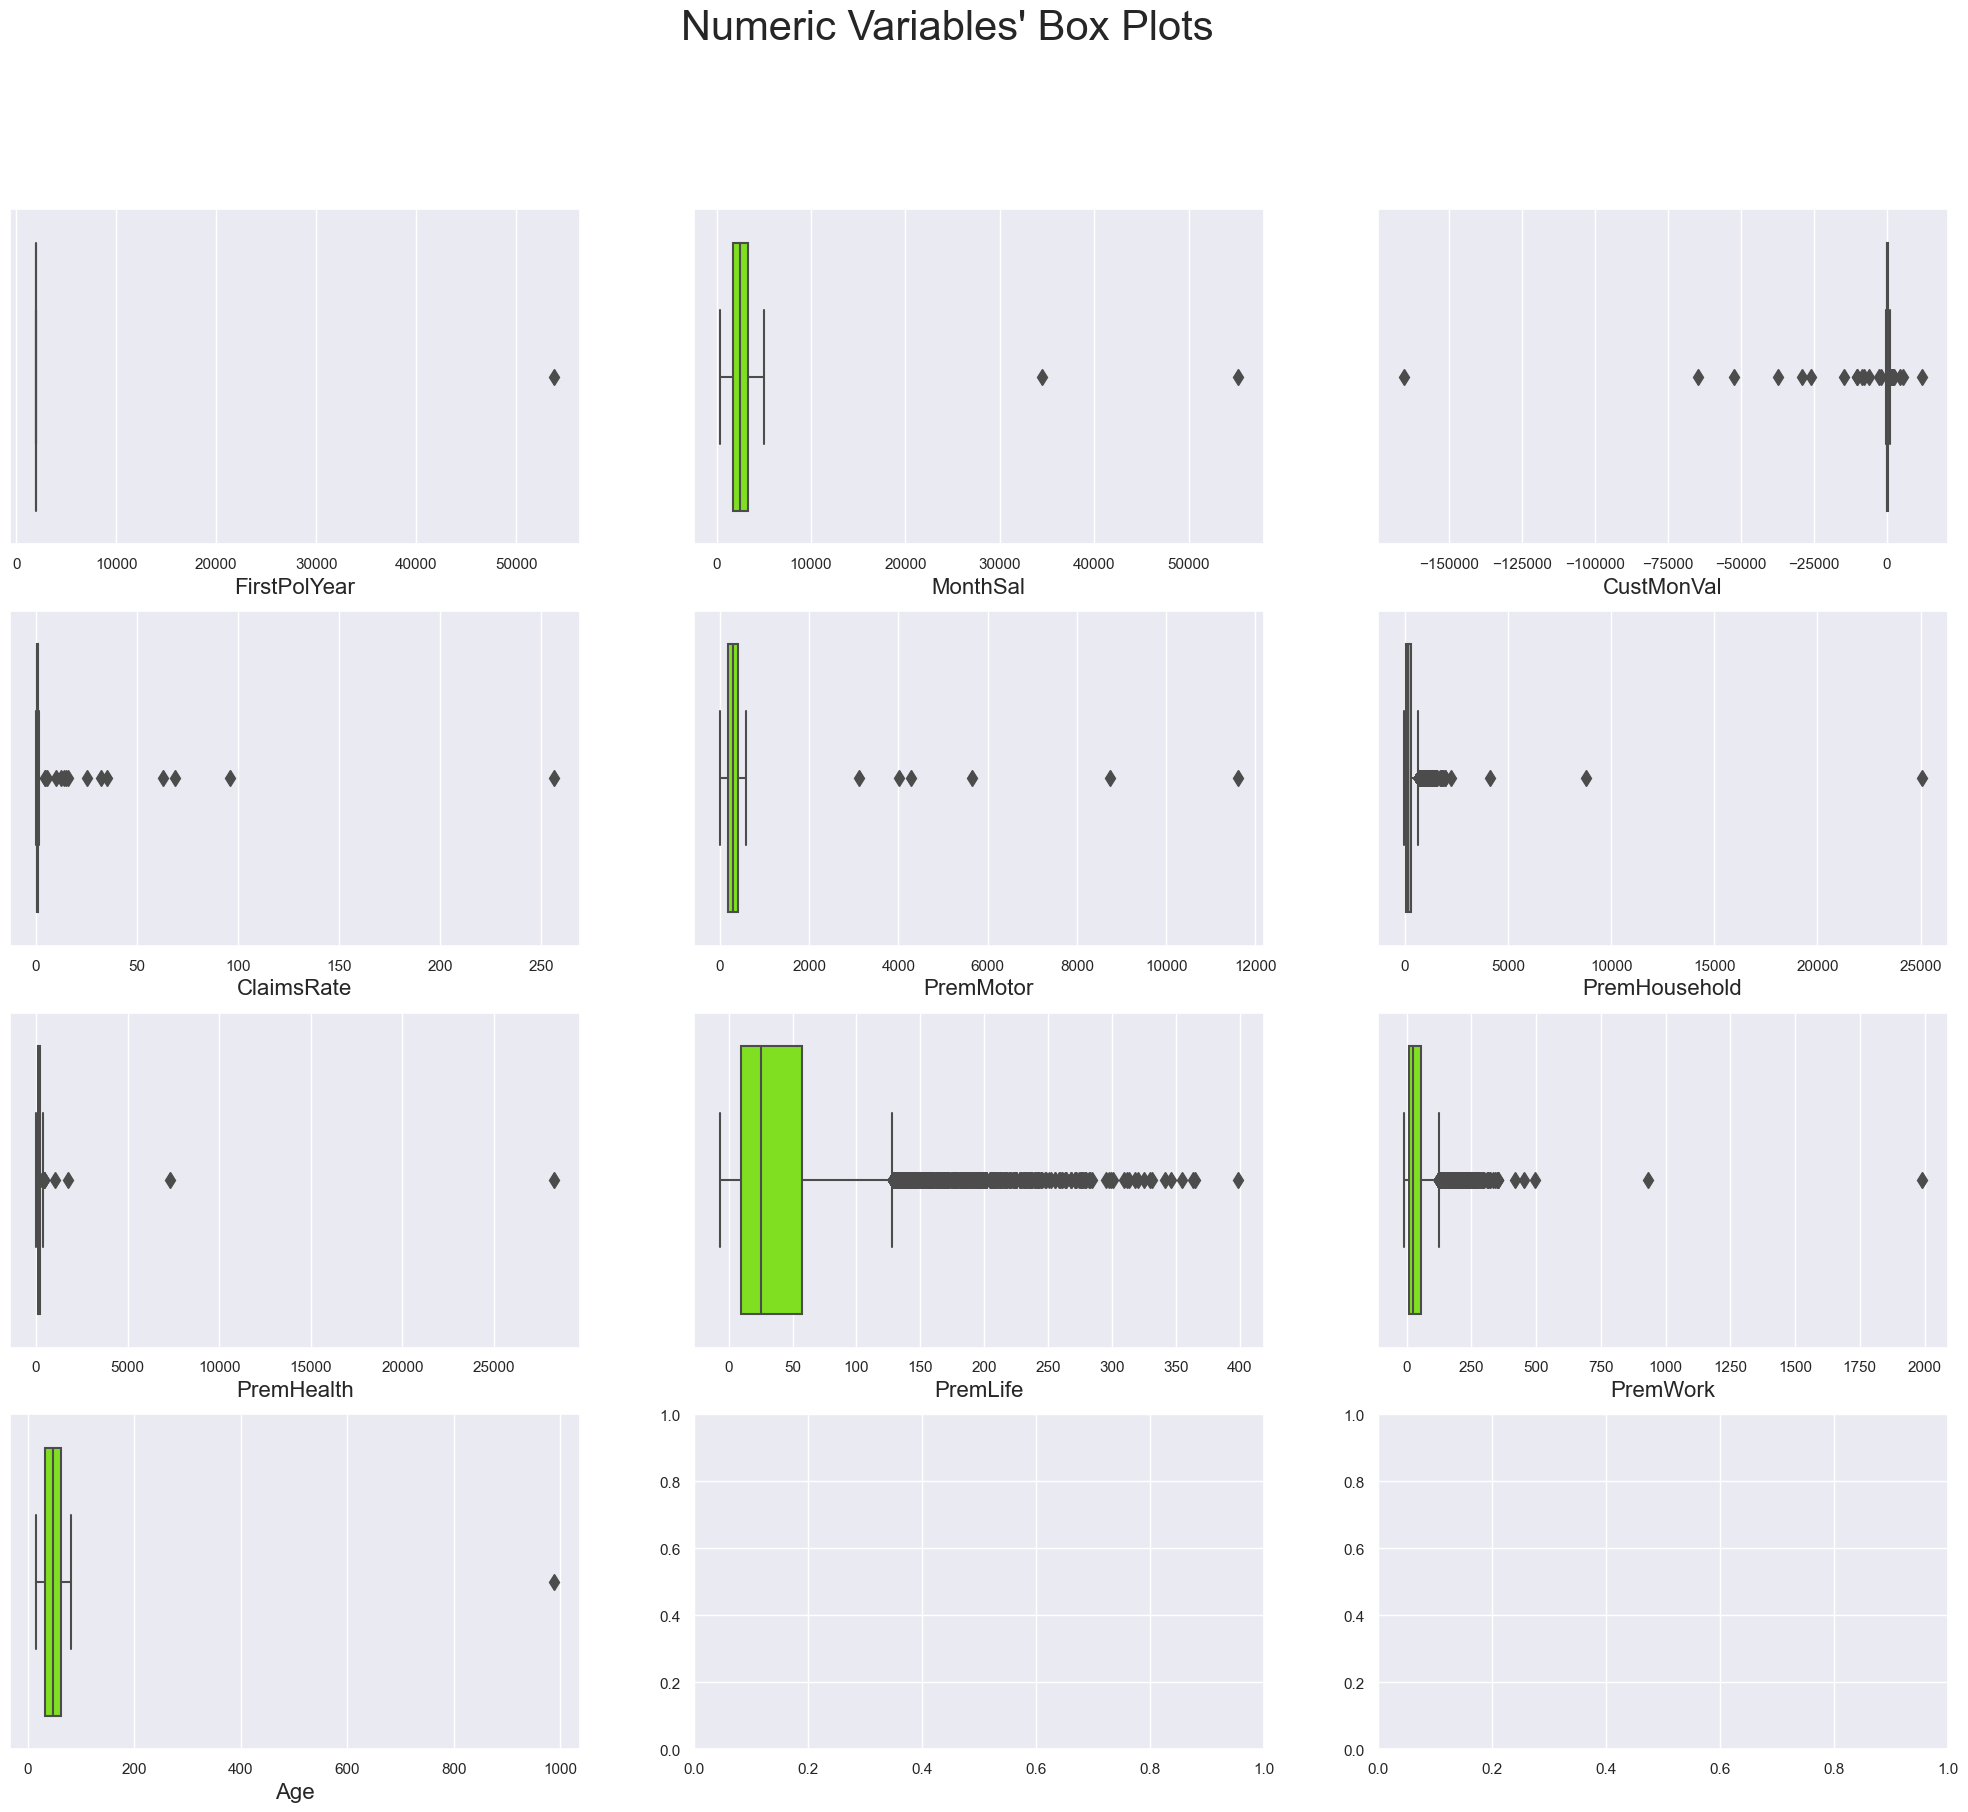

In [145]:
box_plot_all_vars(df)

### Observation method


In [146]:
##Following quartiles
filters1 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=5500)
    &
    (df['CustMonVal']>=-3000)
    &
    (df['CustMonVal']<=3000)
    &
    (df['ClaimsRate']<=6)
    &
    (df['PremMotor']<=700)
    &
    (df['PremHousehold']<=1500)
    &
    (df['PremHealth']<=760)
    &
    (df['PremLife']<=150)
    &
    (df['Age']<=85)
)

df_1 = df[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9553


In [147]:
# df_3['FirstPolYear'].unique()

### IQR method


In [148]:
##IQR method
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2=df.copy()
df_2['filters2'] = filters2.to_list()
df_2=df_2[df_2['filters2']!=False]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.8541


C:\Users\henri\AppData\Local\Temp\ipykernel_1860\2368486648.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q25 = df.quantile(.25)
C:\Users\henri\AppData\Local\Temp\ipykernel_1860\2368486648.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q75 = df.quantile(.75)


### Combining Both

In [149]:
##Combining the 2 above
df_3 = df.copy()
df_3['filters1'] = filters1.to_list()
df_3['filters2'] = filters2
df_3 = df_3[(df_3['filters1']==True) | (df_3['filters2']==True)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9947


### Observation method more conservative

In [150]:
##Removing more critical data points
filters3 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=30000)
    &
    (df['CustMonVal']>=-75000)
    &
    (df['ClaimsRate']<=100)
    &
    (df['PremMotor']<=6000)
    &
    (df['PremHousehold']<=5000)
    &
    (df['PremHealth']<=5000)
    &
    (df['PremLife']<=398)
    &
    (df['Age']<=85)
)

df_4 = df[filters3]
print('Percentage of data kept after removing outliers:', np.round(df_4.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9988


In [151]:
## print para comparar os dois metodos de outliers, e colocar que se escolheu so usar o manual
df_3.drop(columns=['filters1','filters2'], inplace=True)
print('Data shape before outliers removal:')
print(df.shape)
print('Data shape after outliers removal:')
print('df_1: ', df_1.shape)
print('df_2: ', df_2.shape)
print('df_3: ', df_3.shape)
print('df_4: ', df_4.shape)

Data shape before outliers removal:
(10293, 13)
Data shape after outliers removal:
df_1:  (9833, 13)
df_2:  (8791, 14)
df_3:  (10238, 13)
df_4:  (10281, 13)


In [152]:
df=df_1.copy()

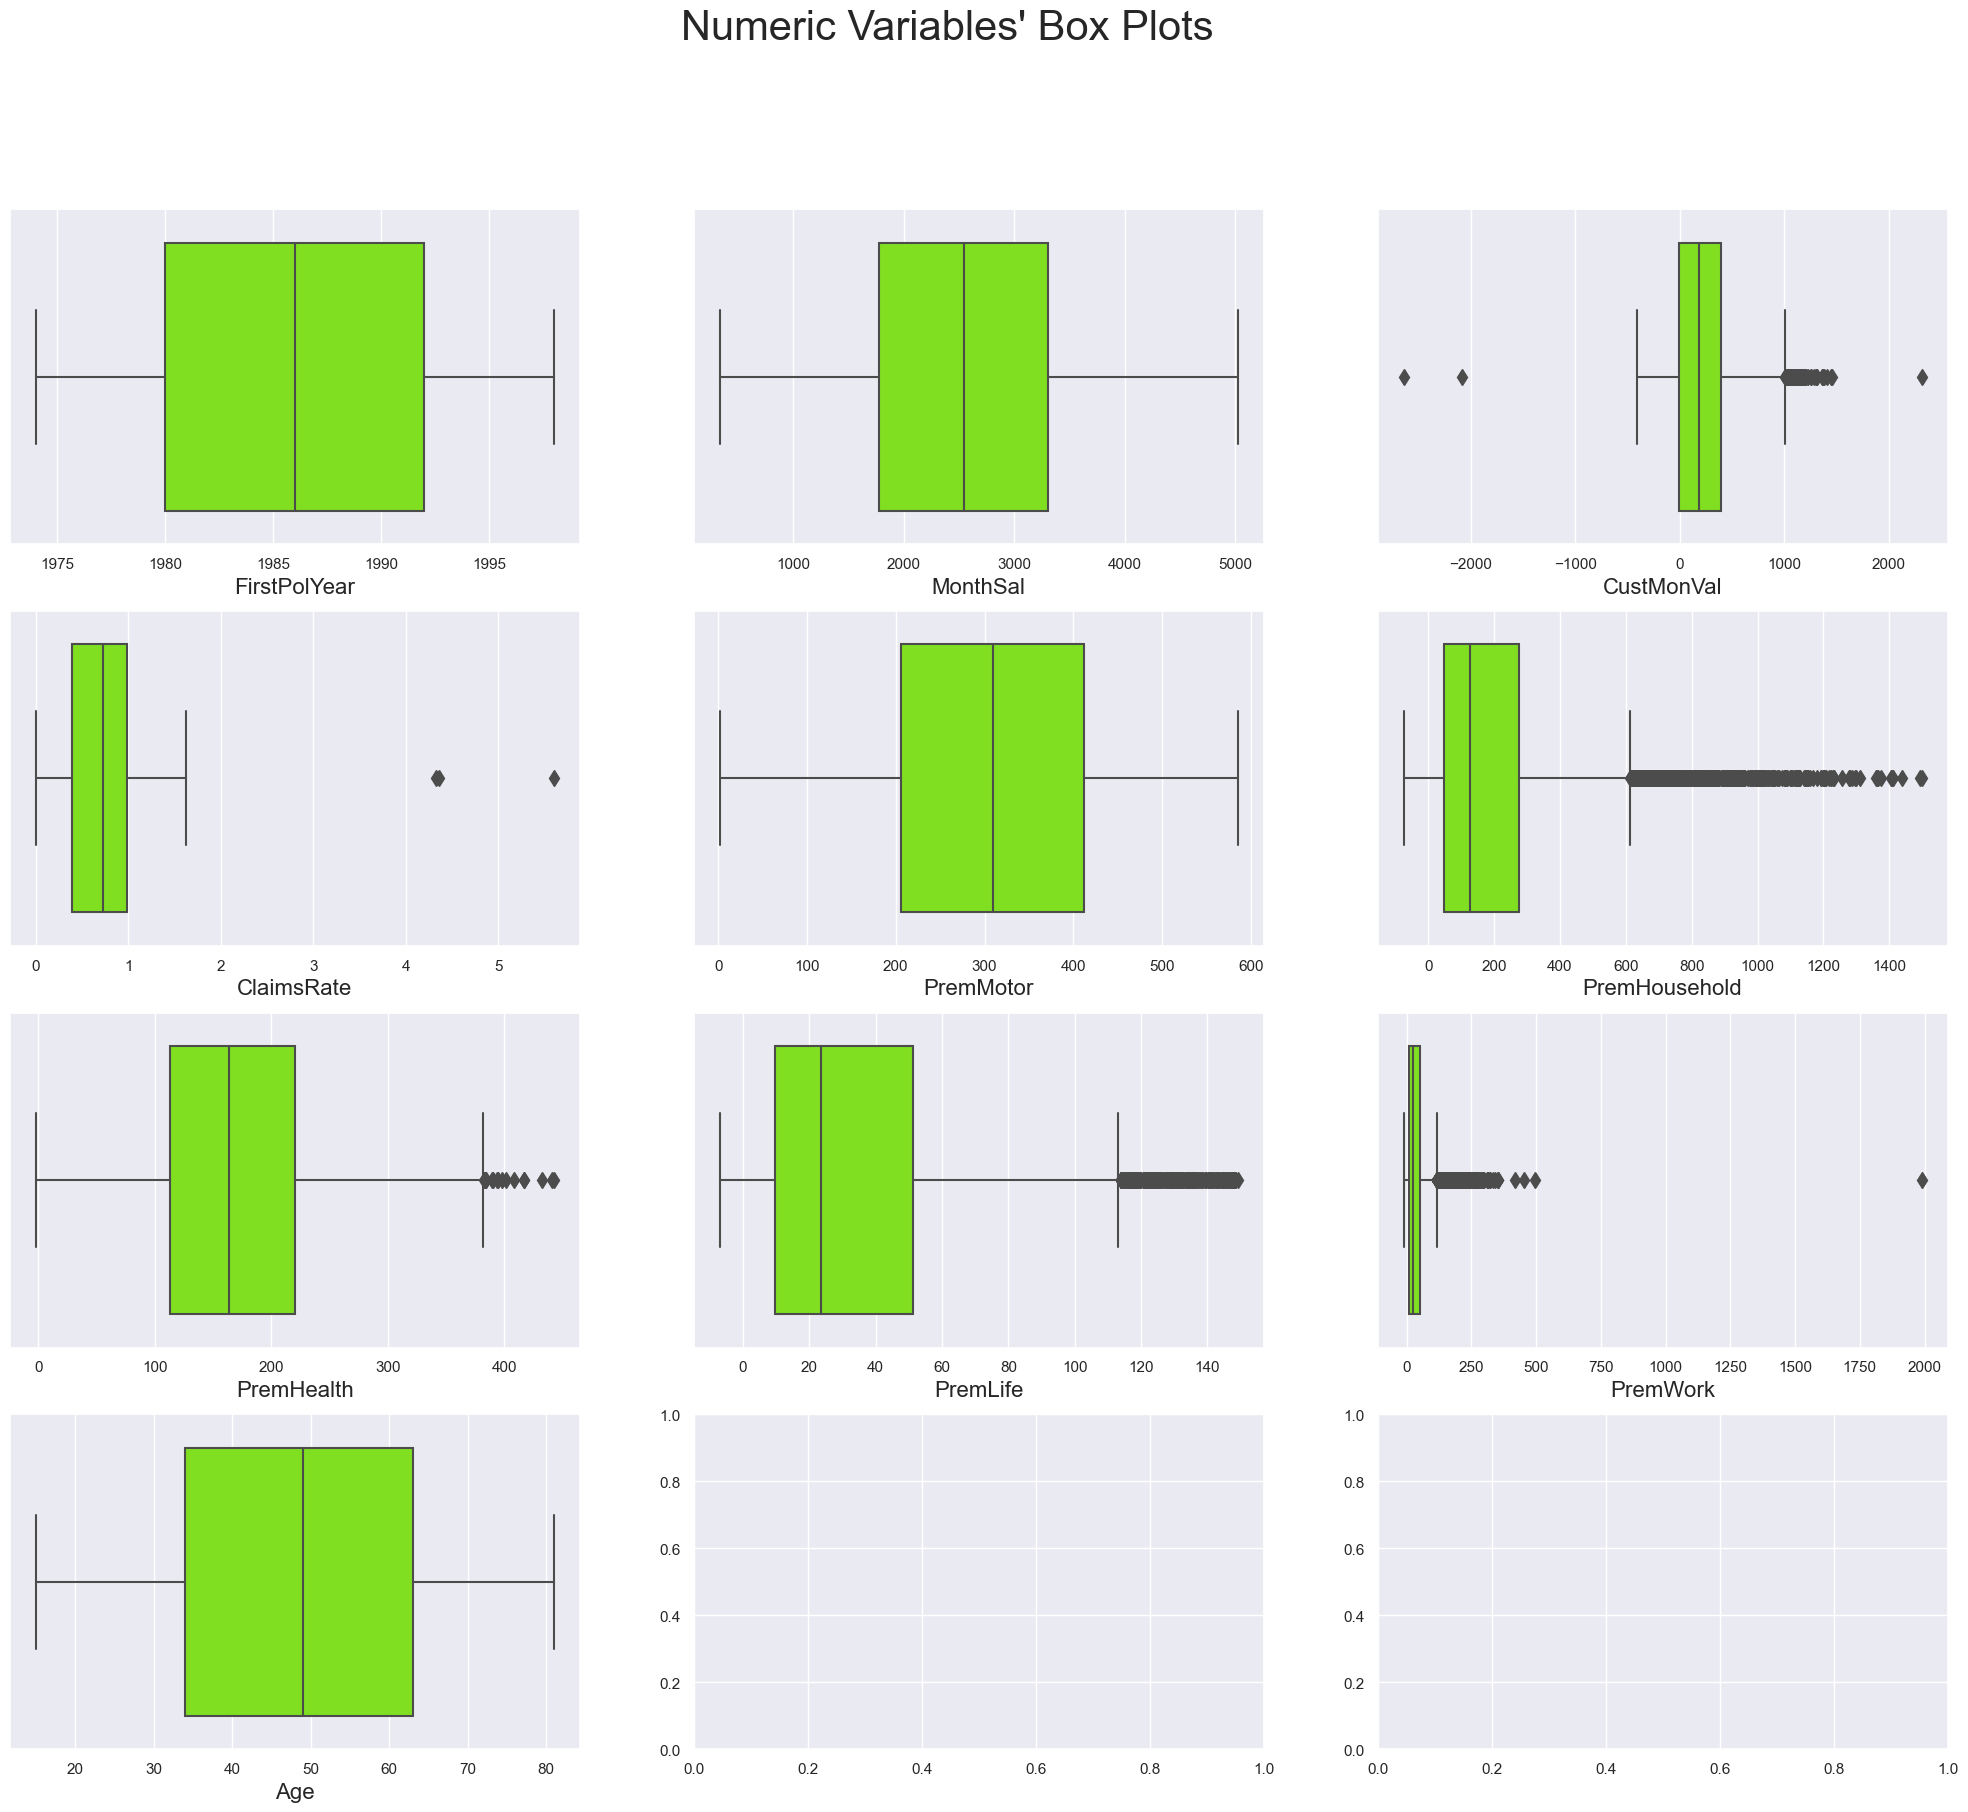

In [153]:
box_plot_all_vars(df)

In [154]:
df['FirstPolYear'].unique()

array([1985, 1991, 1990, 1986, 1979, 1988, 1981, 1976, 1983, 1977, 1998,
       1974, 1978, 1995, 1980, 1984, 1989, 1987, 1982, 1994, 1993, 1992,
       1997, 1996, 1975])

C:\Users\henri\AppData\Local\Temp\ipykernel_1860\2516920713.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_pearson = df.corr()


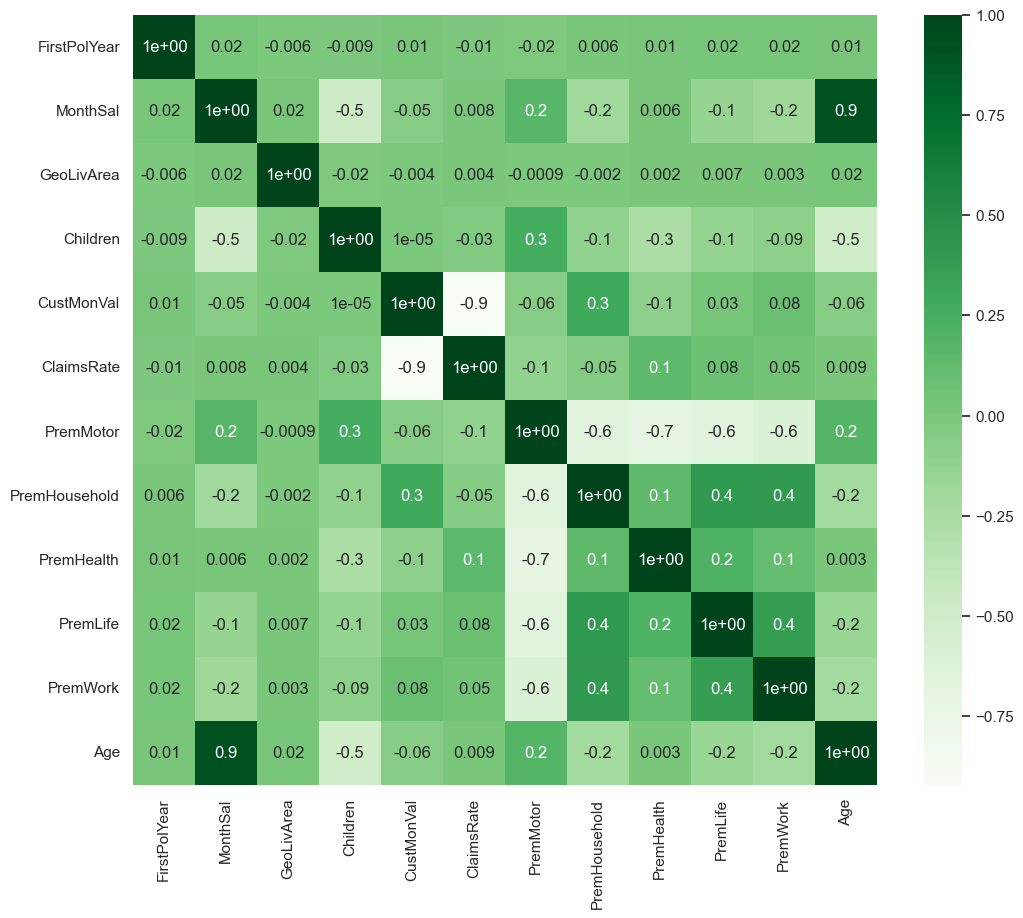

In [155]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Greens, fmt='.1')
    plt.show()
cor_pearson = df.corr()
cor_heatmap(cor_pearson)


In [156]:
##Drop columns with very high correlations
df.drop(columns=['MonthSal','CustMonVal'], inplace=True)
metric_features.remove('MonthSal')
metric_features.remove('CustMonVal')

C:\Users\henri\AppData\Local\Temp\ipykernel_1860\2059977964.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_pearson = df.corr()


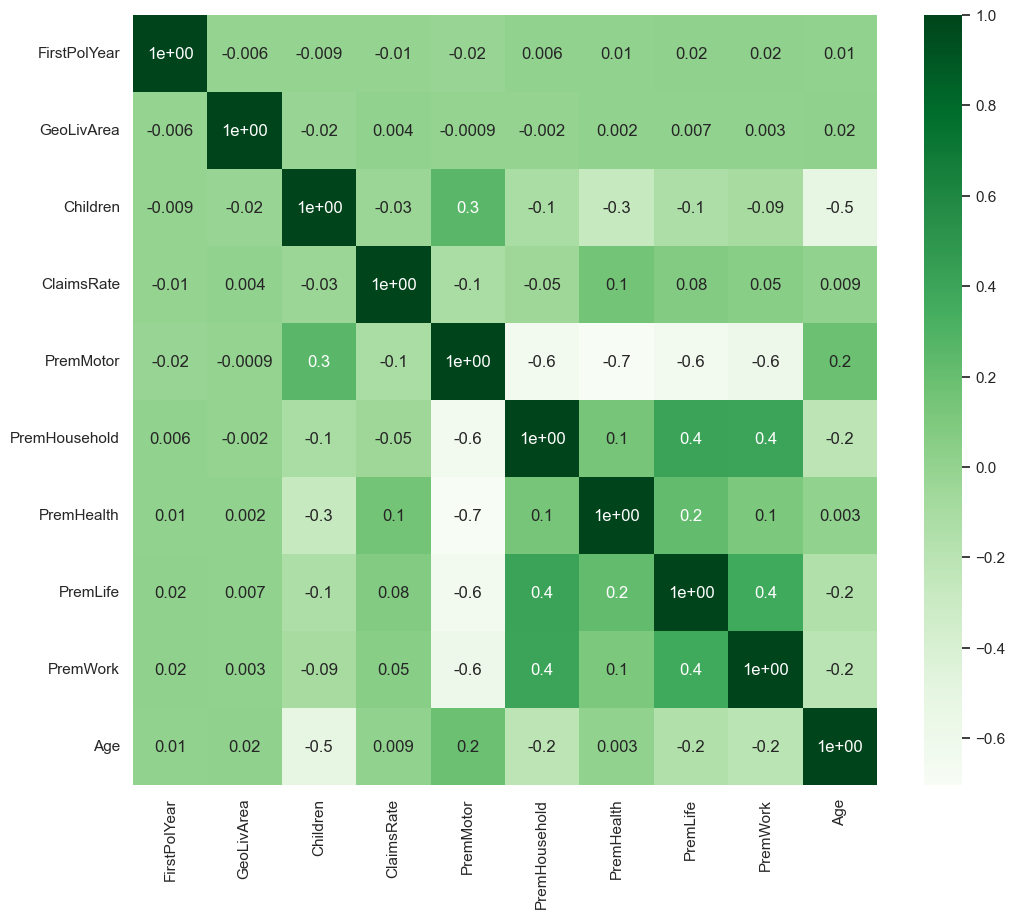

In [157]:
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

In [158]:
df[metric_features].sample(5)

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age
CustID,,,,,,,,
10157,1985,1.06,345.73,-16.10,206.26,30.56,18.67,47
8510,1978,0.74,239.60,210.60,234.71,37.23,45.34,36
1375,1993,0.91,477.09,69.45,99.13,2.89,4.89,61
8730,1975,0.99,176.59,270.05,192.48,-0.11,165.03,32
424,1996,0.85,232.71,-5.00,195.37,148.25,14.67,54


In [159]:
df_not_scaled = df.copy()

### MinMaxScaler

In [160]:
df_minmax=df.copy()
#normalize with minmaxscaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_minmax[metric_features])
df_minmax[metric_features] = scaled_features

df_minmax.describe().T

,count,mean,std,min,25%,50%,75%,max
FirstPolYear,9833.0,0.500970,0.274516,0.0,0.250000,0.500000,0.750000,1.0
GeoLivArea,9833.0,2.706193,1.265996,1.0,1.000000,3.000000,4.000000,4.0
Children,9833.0,0.709753,0.453899,0.0,0.000000,1.000000,1.000000,1.0
ClaimsRate,9833.0,0.121275,0.058205,0.0,0.069643,0.128571,0.175000,1.0
PremMotor,9833.0,0.522639,0.227486,0.0,0.350285,0.528383,0.703620,1.0
PremHousehold,9833.0,0.171569,0.140285,0.0,0.078415,0.128922,0.222180,1.0
PremHealth,9833.0,0.385104,0.167508,0.0,0.258489,0.373126,0.501000,1.0
PremLife,9833.0,0.268270,0.218464,0.0,0.107468,0.196426,0.372230,1.0
PremWork,9833.0,0.025641,0.024651,0.0,0.010941,0.018329,0.032549,1.0
Age,9833.0,0.510651,0.256336,0.0,0.287879,0.515152,0.727273,1.0


### StandartScaler

In [161]:
df_st_scaler=df.copy()
#normalize with standart scaler
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
standart_scaler_features = standart_scaler.fit_transform(df_st_scaler[metric_features])
df_st_scaler[metric_features] = standart_scaler_features

df_st_scaler.describe().T

,count,mean,std,min,25%,50%,75%,max
FirstPolYear,9833.0,2.353542e-15,1.000051,-1.825015,-0.914275,-0.003535,0.907205,1.817945
GeoLivArea,9833.0,2.706193e+00,1.265996,1.000000,1.000000,3.000000,4.000000,4.000000
Children,9833.0,7.097529e-01,0.453899,0.000000,0.000000,1.000000,1.000000,1.000000
ClaimsRate,9833.0,8.400345e-17,1.000051,-2.083683,-0.887115,0.125365,0.923076,15.097795
PremMotor,9833.0,1.517482e-16,1.000051,-2.297576,-0.757687,0.025255,0.795613,2.098532
PremHousehold,9833.0,-3.902096e-17,1.000051,-1.223062,-0.664069,-0.304019,0.360791,5.905637
PremHealth,9833.0,1.250116e-16,1.000051,-2.299134,-0.755911,-0.071510,0.691917,3.671028
PremLife,9833.0,2.997026e-16,1.000051,-1.228041,-0.736093,-0.328873,0.475893,3.349596
PremWork,9833.0,4.769228e-17,1.000051,-1.040226,-0.596362,-0.296667,0.280214,39.528021
Age,9833.0,-1.474125e-16,1.000051,-1.992219,-0.869107,0.017560,0.845115,1.909116


### Robust Scaler

In [162]:
df_robust_scaler=df.copy()
#normalize with robust scaler
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
robust_scaler_features = robust_scaler.fit_transform(df_robust_scaler[metric_features])
df_robust_scaler[metric_features] = robust_scaler_features

df_robust_scaler.describe().T

,count,mean,std,min,25%,50%,75%,max
FirstPolYear,9833.0,0.001941,0.549032,-1.000000,-0.500000,0.0,0.500000,1.000000
GeoLivArea,9833.0,2.706193,1.265996,1.000000,1.000000,3.0,4.000000,4.000000
Children,9833.0,0.709753,0.453899,0.000000,0.000000,1.0,1.000000,1.000000
ClaimsRate,9833.0,-0.069255,0.552456,-1.220339,-0.559322,0.0,0.440678,8.271186
PremMotor,9833.0,-0.016259,0.643823,-1.495416,-0.504050,0.0,0.495950,1.334756
PremHousehold,9833.0,0.296645,0.975793,-0.896750,-0.351315,0.0,0.648685,6.059032
PremHealth,9833.0,0.049391,0.690725,-1.538597,-0.472709,0.0,0.527291,2.584932
PremLife,9833.0,0.271350,0.825134,-0.741896,-0.335994,0.0,0.664006,3.035075
PremWork,9833.0,0.338439,1.140861,-0.848254,-0.341892,0.0,0.658108,45.432107
Age,9833.0,-0.010243,0.583384,-1.172414,-0.517241,0.0,0.482759,1.103448


### Choosing scaler method

In [163]:
df=df_st_scaler.copy()
df_cat_num = df_st_scaler.copy()
# df=df_minmax.copy()

In [164]:
df.isna().sum()

FirstPolYear     0
EducDeg          0
GeoLivArea       0
Children         0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
Age              0
dtype: int64

In [165]:
df[non_metric_features]

,EducDeg,Children,GeoLivArea
CustID,,,
1,b'2 - High School',1,1
3,b'1 - Basic',0,3
4,b'3 - BSc/MSc',1,4
5,b'3 - BSc/MSc',1,4
6,b'2 - High School',1,4
...,...,...,...
10292,b'4 - PhD',0,2
10293,b'1 - Basic',0,3
10294,b'3 - BSc/MSc',1,1


### One Hot Encoder
#### Using standart scaled DF

In [166]:
##ONE HOT ENCODING
df_ohc = df[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df

c:\Users\henri\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4
CustID,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
10292,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10294,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [167]:
df_scaled=df.merge(ohc_df, on = 'CustID')
df_scaled.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_scaled

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4
CustID,,,,,,,,,,,,,,,,,
1,-0.155325,-0.887115,0.520969,-0.523131,-0.307112,0.355398,-0.454423,-0.869107,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.755415,-1.224609,-0.757687,0.134203,-0.599335,1.508749,1.210930,-0.159774,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.603625,0.953757,-0.936036,-0.686727,1.904143,0.013263,-0.222251,-0.809996,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,-0.003535,0.677626,0.240449,-0.666561,0.178985,-0.472235,0.043581,-0.337107,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6,-0.003535,0.984438,1.009978,-0.797529,-0.730553,-0.817596,-0.641377,0.667782,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,-0.307115,0.861714,0.655767,-0.659084,0.061184,-0.736093,-0.497207,1.081560,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,-1.369645,-2.083683,-1.304488,3.810600,-0.348839,-0.644916,1.334822,0.904227,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10294,1.210785,-1.439377,0.730286,-0.281361,-0.362256,-0.651366,-0.697747,-0.514441,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


#### Using MinMaxScaler

In [168]:
##ONE HOT ENCODING
df_ohc = df_minmax[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df

c:\Users\henri\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4
CustID,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
10292,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10294,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [169]:
df_minmax=df_minmax.merge(ohc_df, on = 'CustID')
df_minmax.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_minmax

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4
CustID,,,,,,,,,,,,,,,,,
1,0.458333,0.069643,0.641146,0.098185,0.333663,0.345908,0.014440,0.287879,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.708333,0.050000,0.350285,0.190394,0.284716,0.597861,0.055491,0.469697,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.666667,0.176786,0.309715,0.075236,0.704047,0.271167,0.020163,0.303030,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.500000,0.160714,0.577334,0.078065,0.415084,0.165108,0.026716,0.424242,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.500000,0.178571,0.752382,0.059693,0.262737,0.089663,0.009832,0.681818,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,0.416667,0.171429,0.671809,0.079114,0.395352,0.107468,0.013385,0.787879,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,0.125000,0.000000,0.225902,0.706112,0.326674,0.127386,0.058545,0.742424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10294,0.833333,0.037500,0.688760,0.132100,0.324426,0.125977,0.008442,0.378788,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


### Keep one hot from standart scaler

In [170]:
df=df_scaled.copy()
df

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4
CustID,,,,,,,,,,,,,,,,,
1,-0.155325,-0.887115,0.520969,-0.523131,-0.307112,0.355398,-0.454423,-0.869107,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.755415,-1.224609,-0.757687,0.134203,-0.599335,1.508749,1.210930,-0.159774,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.603625,0.953757,-0.936036,-0.686727,1.904143,0.013263,-0.222251,-0.809996,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,-0.003535,0.677626,0.240449,-0.666561,0.178985,-0.472235,0.043581,-0.337107,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6,-0.003535,0.984438,1.009978,-0.797529,-0.730553,-0.817596,-0.641377,0.667782,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,-0.307115,0.861714,0.655767,-0.659084,0.061184,-0.736093,-0.497207,1.081560,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,-1.369645,-2.083683,-1.304488,3.810600,-0.348839,-0.644916,1.334822,0.904227,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10294,1.210785,-1.439377,0.730286,-0.281361,-0.362256,-0.651366,-0.697747,-0.514441,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [171]:
# ProfileReport(
#     df,
#     title='Data Preprocessed Analysis',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

## PCA
#### Using standart scaler df

In [172]:
# ##PCA
# df_pca = df.copy()


# pca = PCA()
# pca_feat = pca.fit_transform(df_pca[metric_features])

In [173]:
# pd.DataFrame(
#     {"Eigenvalue": pca.explained_variance_,
#      "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
#      "Proportion": pca.explained_variance_ratio_,
#      "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
#     index=range(1, pca.n_components_ + 1)
# )

##### We can notice that only a reduction to 5 components (~82%) would be representative of the data set. Since originally, we had 13 features, it doesn't make sense to keep 5 components.
#### Let's try with the df from min max scaler...


In [174]:
# ##PCA
# df_pca_min_max = df_minmax.copy()


# pca_min_max = PCA()
# pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])

In [175]:
# pd.DataFrame(
#     {"Eigenvalue": pca_min_max.explained_variance_,
#      "Difference": np.insert(np.diff(pca_min_max.explained_variance_), 0, 0),
#      "Proportion": pca_min_max.explained_variance_ratio_,
#      "Cumulative": np.cumsum(pca_min_max.explained_variance_ratio_)},
#     index=range(1, pca_min_max.n_components_ + 1)
# )

##### Now it's clear that with only 3 components, we have 90% of explained variance
##### Let's keep this DF to visualize PCA

In [176]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


# ax1.plot(pca_min_max.explained_variance_, marker=".", markersize=12)
# ax2.plot(pca_min_max.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
# ax2.plot(np.cumsum(pca_min_max.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


# ax2.legend()
# ax1.set_title("Scree Plot", fontsize=14)
# ax2.set_title("Variance Explained", fontsize=14)
# ax1.set_ylabel("Eigenvalue")
# ax2.set_ylabel("Proportion")
# ax1.set_xlabel("Components")
# ax2.set_xlabel("Components")
# ax1.set_xticks(range(0, pca_min_max.n_components_, 2))
# ax1.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))
# ax2.set_xticks(range(0, pca_min_max.n_components_, 2))
# ax2.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))

# plt.show()

In [177]:
# pca_min_max = PCA(n_components=3)
# pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])
# pca_feat_names = [f"PC{i}" for i in range(pca_min_max.n_components_)]
# pca_df = pd.DataFrame(pca_feat_min_max, index=df_pca_min_max.index, columns=pca_feat_names) 
# pca_df

In [178]:
# df_pca_min_max = pd.concat([df_pca_min_max, pca_df], axis=1)
# df_pca_min_max.head()

In [179]:
# def _color_red_or_green(val):
#     if val < -0.45:
#         color = 'background-color: red'
#     elif val > 0.45:
#         color = 'background-color: green'
#     else:
#         color = ''
#     return color
    


# # Interpreting each Principal Component
# loadings = df_pca_min_max[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
# loadings.style.applymap(_color_red_or_green)

In [180]:
# df_pca_min_max['HighScore'] = df_pca_min_max[['PC0', 'PC1', 'PC2']].idxmax(axis=1)
# df_pca_min_max

### At this point, we have 2 different Dataframes. One from min max scaler with 3 Principal components. And another from standart scaler without PCA.
#### Let's see wich one performs best when doing clustering

In [181]:
# df_pca_min_max.head()

In [182]:
# df = df_pca.copy()
# df.head()

# NEW

### DBSCAN

---
### Gaussian

In [183]:
from sklearn.mixture import GaussianMixture
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df[metric_features])
labels_proba = gmm.predict_proba(df[metric_features])

In [184]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

(4, 8, 8)

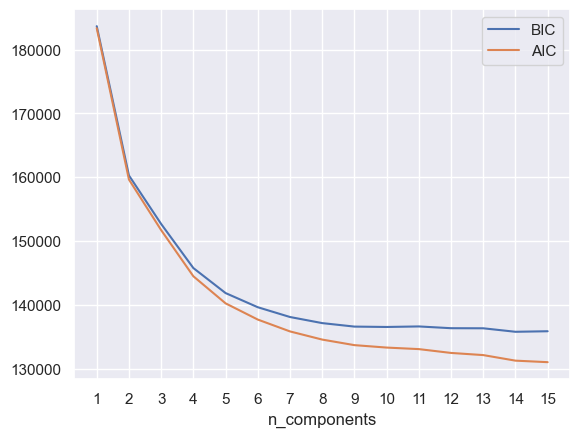

In [185]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
          for n in n_components]

bic_values = [m.bic(df[metric_features]) for m in models]
aic_values = [m.aic(df[metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [186]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df[metric_features])

In [187]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,gmm_labels
CustID,,,,,,,,,
1,-0.155325,-0.887115,0.520969,-0.523131,-0.307112,0.355398,-0.454423,-0.869107,0
3,0.755415,-1.224609,-0.757687,0.134203,-0.599335,1.508749,1.210930,-0.159774,1
4,0.603625,0.953757,-0.936036,-0.686727,1.904143,0.013263,-0.222251,-0.809996,3
5,-0.003535,0.677626,0.240449,-0.666561,0.178985,-0.472235,0.043581,-0.337107,3
6,-0.003535,0.984438,1.009978,-0.797529,-0.730553,-0.817596,-0.641377,0.667782,3


In [188]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [189]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3331


In [190]:
df_concat['gmm_labels'].value_counts()

1    4775
3    2230
0    2189
2     639
Name: gmm_labels, dtype: int64

In [191]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

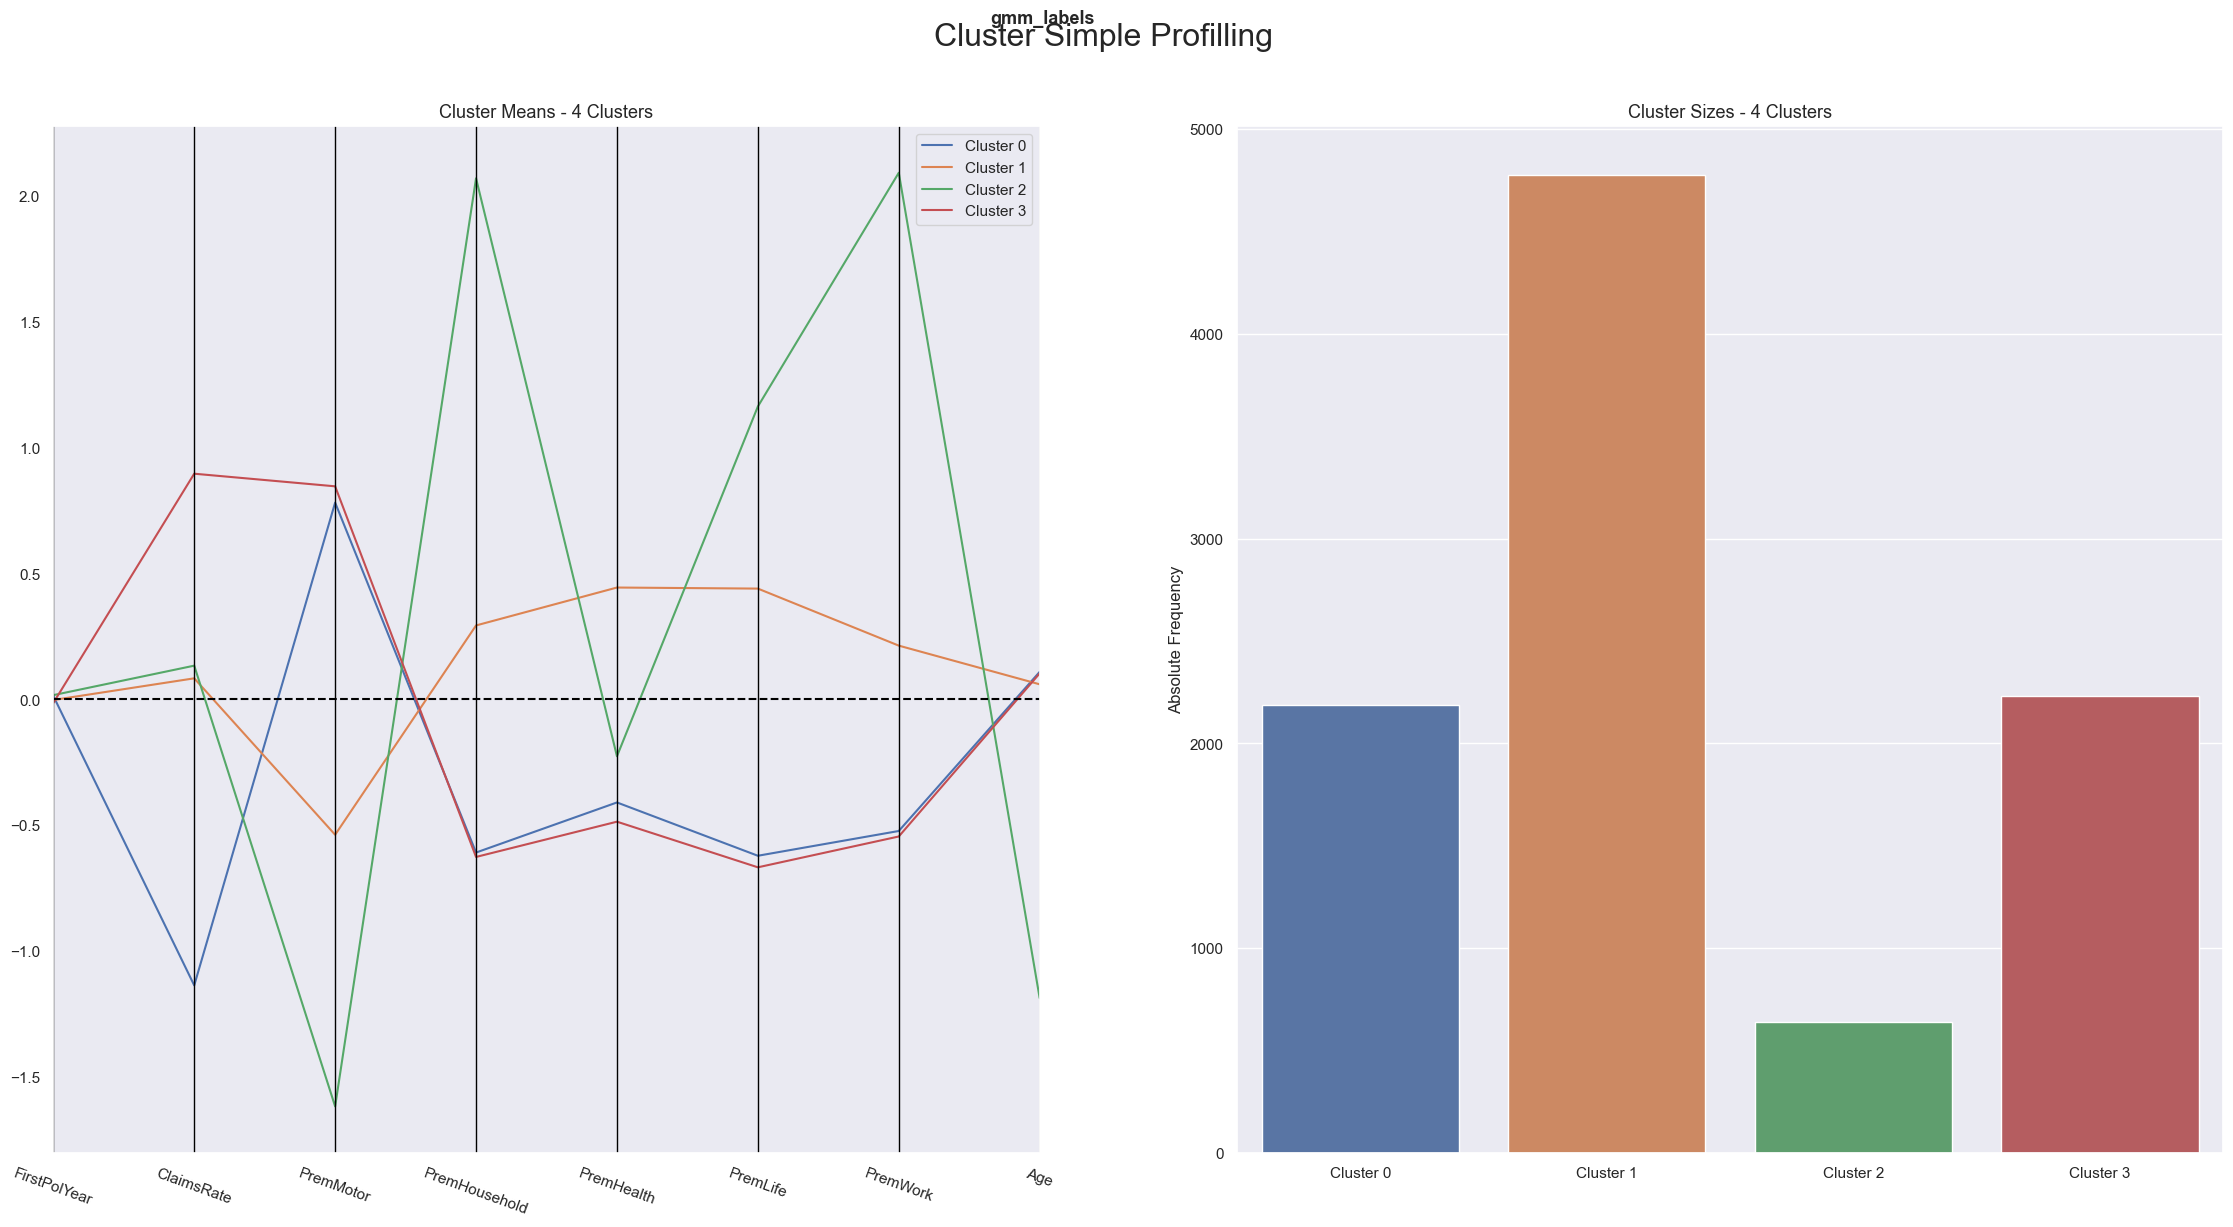

In [192]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_concat[metric_features + ['gmm_labels']], 
    label_columns = ['gmm_labels'], 
    figsize = (28, 13), 
    compar_titles = ["gmm_labels"]
)

In [193]:
# from sklearn.manifold import TSNE
# # This is step can be quite time consuming
# two_dim = TSNE(random_state=42).fit_transform(df_concat[metric_features])

In [194]:
# # t-SNE visualization
# pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_concat['gmm_labels'], colormap='tab10', figsize=(15,10))
# plt.show()

---
### Splitting variables perspectives

#### - Removing DBSCAN outliers

In [195]:
# Based on the hyperparameters found in the previous class
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])
Counter(dbscan_labels)

Counter({0: 9748, -1: 85})

In [196]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers and 'rcn'
df = df[dbscan_labels!=-1]\
    .copy()

df_cat_num = df_cat_num[df_cat_num.index.isin(df.index)]
df_not_scaled = df_not_scaled[df_not_scaled.index.isin(df.index)]


In [197]:
df_not_scaled

,FirstPolYear,EducDeg,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age
CustID,,,,,,,,,,,
1,1985,b'2 - High School',1,1,0.39,375.85,79.45,146.36,47.01,16.89,34
3,1991,b'1 - Basic',3,0,0.28,206.15,224.50,124.58,86.35,99.02,46
4,1990,b'3 - BSc/MSc',4,1,0.99,182.48,43.35,311.17,35.34,28.34,35
5,1986,b'3 - BSc/MSc',4,1,0.90,338.62,47.80,182.59,18.78,41.45,43
6,1986,b'2 - High School',4,1,1.00,440.75,18.90,114.80,7.00,7.67,60
...,...,...,...,...,...,...,...,...,...,...,...
10291,1994,b'1 - Basic',3,1,0.85,6.89,878.50,103.13,113.02,201.26,17
10292,1984,b'4 - PhD',2,0,0.96,393.74,49.45,173.81,9.78,14.78,67
10294,1994,b'3 - BSc/MSc',1,1,0.21,403.63,132.80,142.25,12.67,4.89,40


In [198]:
metric_features

['FirstPolYear',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'Age']

In [199]:
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[10, 10],  # NEEDS TO BE A LIST
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.051000, quantization error: 2.675692

 epoch: 2 ---> elapsed time:  0.121000, quantization error: 2.637306

 epoch: 3 ---> elapsed time:  0.048000, quantization error: 2.568238

 epoch: 4 ---> elapsed time:  0.034000, quantization error: 2.530839

 epoch: 5 ---> elapsed time:  0.034000, quantization error: 2.496604

 epoch: 6 ---> elapsed time:  0.035000, quantization error: 2.484114

 epoch: 7 ---> elapsed time:  0.034000, quantization error: 2.475976

 epoch: 8 ---> elapsed time:  0.034000, quantization error: 2.469953

 epoch: 9 ---> elapsed time:  0.037000, quantization error: 2.466664

 epoch: 10 ---> elapsed time:  0.034000, quantization error: 2.463715

 epoch: 11 ---> elapsed time:  0.035000, quantization error: 2.460786

 epoch: 12 ---> elapsed time:  0.034000, quantization error: 2.457831

 epoch: 13 ---> 

In [200]:
plt.rcParams['figure.dpi'] = 72
weights = sm.codebook.matrix 

In [201]:
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors

from matplotlib.lines import Line2D
from matplotlib import __version__ as mplver
###################################
### Visualizing Component Planes ##
###################################

def plot_component_planes(weights,
                          features,
                          M=3, N=4, 
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):
    
    xx, yy = np.meshgrid(np.arange(M), np.arange(N))
    xx = xx.astype(float)
    yy = yy.astype(float)

    xx[::-2] -= 0.5

    xx = xx.T
    yy = yy.T
    
    weights_ = weights.reshape((M,N,len(features)))

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    ## Normalize color scale to range of all values
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))

    for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1, )
        axs.set_aspect('equal')

        ## Normalize color scale to range of values in each component
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:,:,cpi]), 
                                         vmax=np.max(weights_[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights_[i, j, cpi])), 
                                     alpha=1, 
                                     linewidth=.5,
                                     edgecolor=cmap(colornorm(weights_[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)


        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()

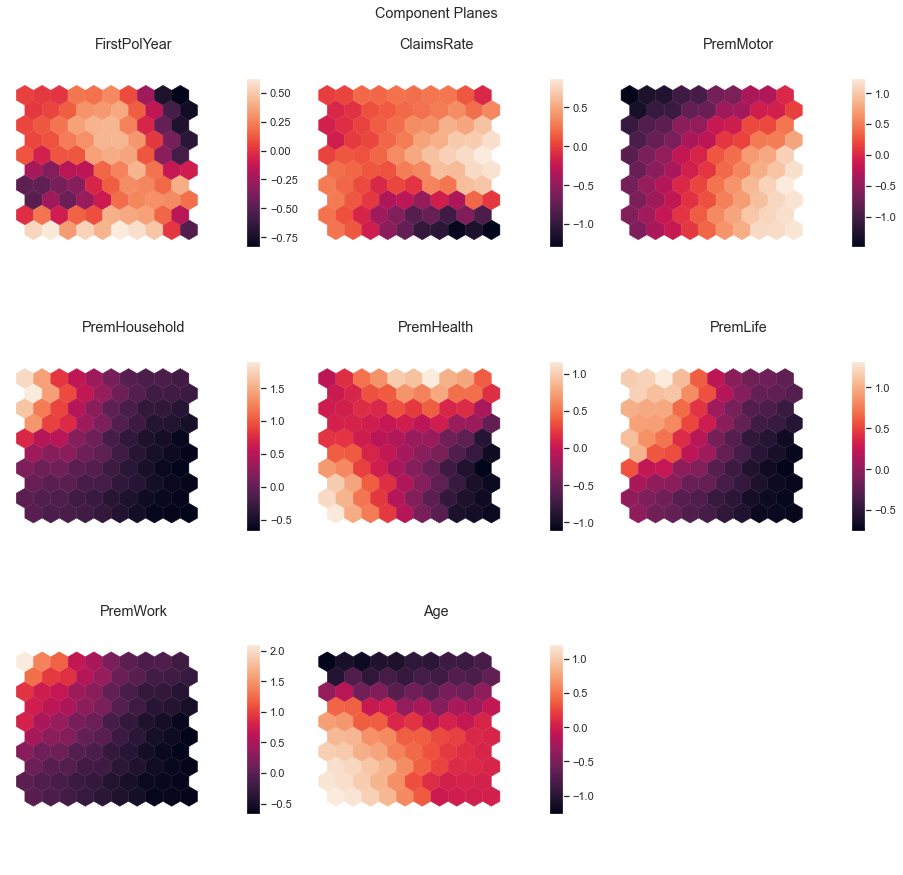

In [202]:
plot_component_planes(weights=sm.codebook.matrix,features=metric_features,
                     M=10,N=10,
                     figsize=(12,12),figlayout=(3,3),
                     title="Component Planes",
                     cmap=sns.color_palette("rocket", as_cmap=True))


In [203]:
# # Here you have U-matrix
# u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

# UMAT = u.show(
#     sm, 
#     distance=2,
#     row_normalized=False,
#     show_data=True, 
#     contour=True, # Visualize isomorphic curves
#     blob=True
# )

# np.flip(UMAT[1], axis=1) # U-matrix values - they match with the plot colors

In [204]:
# vhts  = BmuHitsView(12,12,"Hits Map")
# vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
# plt.show()

---
### Split variables into perspectives
#### - Remove geolivArea because almost doesn't have correlations with any other variable
#### - Remove FirstPolYear because the SOM's units were indistinguishable on this variable

In [205]:
#Split variables into perpectives
demographic=['Age', "EducDeg_b'1 - Basic'", "EducDeg_b'2 - High School'","EducDeg_b'3 - BSc/MSc'","EducDeg_b'4 - PhD'","Children_1"]

insurance=['ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']

metric_features.remove('FirstPolYear')

df_demo=df[demographic].copy()
df_insurance=df[insurance].copy()



#### Clustering with SOM's

In [206]:
# # This som implementation does not have a random seed parameter
# # We're going to set it up ourselves
# np.random.seed(42)

# # Notice that the SOM did not converge - We're under a time constraint for this class
# sm = sompy.SOMFactory().build(
#     df[metric_features].values, 
#     mapsize=[50, 50],  # NEEDS TO BE A LIST
#     initialization='random',
#     neighborhood='gaussian',
#     training='batch',
#     lattice='hexa',
#     component_names=metric_features
# )
# sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

In [207]:
# ### Use this if cell below does not work

# plot_component_planes(weights=sm.codebook.matrix,features=metric_features,
#                      M=50,N=50,
#                      figsize=(12,13),figlayout=(3,3),
#                      title="Component Planes 50x50",
#                      cmap=sns.color_palette("rocket", as_cmap=True))


In [208]:
# # U-matrix of the 50x50 grid
# u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

# UMAT = u.show(
#     sm, 
#     distance=2, 
#     row_normalized=False, 
#     show_data=False, 
#     contour=True # Visualize isomorphic curves
# )

In [209]:
# range_clusters = range(1, 11)
# inertia = []
# for n_clus in range_clusters:  # iterate over desired ncluster range
#     kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
#     kmclust.fit(df[metric_features])
#     inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution


In [210]:
# # The inertia plot
# plt.figure(figsize=(9,5))
# plt.plot(inertia)
# plt.ylabel("Inertia: SSw")
# plt.xlabel("Number of clusters")
# plt.title("Inertia plot over clusters", size=15)
# plt.show()

In [211]:
# # Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
# kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
# nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
# sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

# hits = HitMapView(12, 12,"Clustering", text_size=10)
# hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

# plt.show()

In [212]:
# # Check the nodes and and respective clusters
# nodes = sm.codebook.matrix

# df_nodes = pd.DataFrame(nodes, columns=metric_features)
# df_nodes['label'] = nodeclus_labels
# df_nodes

In [213]:
# df_nodes['label'].value_counts()

In [214]:
# # Characterizing the final clusters
# df_nodes_means = df_nodes.groupby('label').mean().copy()
# df_nodes_means


In [215]:
# # Profilling each cluster (product, behavior, merged)
# cluster_profiles(
#     df = df_nodes[metric_features + ['label']], 
#     label_columns = ['label'], 
#     figsize = (28, 13), 
#     compar_titles = ["label"]
# )

In [216]:
# cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#8B8378', '#FFEFDB', '#0000FF', '#A52A2A']

# class Radar(object):
#     def __init__(self, figure, title, labels, rect=None):
#         if rect is None:
#             rect = [0.05, 0.05, 0.9, 0.9]

#         self.n = len(title)
#         self.angles = np.arange(0, 360, 360.0/self.n)
        
#         self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
#         self.ax = self.axes[0]
#         self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
#         self.ax.set_yticklabels([])
        
#         for ax in self.axes[1:]:
#             ax.xaxis.set_visible(False)
#             ax.set_yticklabels([])
#             ax.set_zorder(-99)

#         for ax, angle, label in zip(self.axes, self.angles, labels):
#             ax.spines['polar'].set_color('black')
#             ax.spines['polar'].set_zorder(-99)
                     
#     def plot(self, values, *args, **kw):
#         angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
#         values = np.r_[values, values[0]]
#         self.ax.plot(angle, values, *args, **kw)
#         kw['label'] = '_noLabel'
#         self.ax.fill(angle, values,*args,**kw)

# fig = plt.figure(figsize=(8, 8))
# no_features = len(metric_features)
# radar = Radar(fig, metric_features, np.unique(df_nodes['label']))

# for k in range(0,len(np.unique(df_nodes['label']))):
#     cluster_data = df_nodes_means.T[k].values.tolist()
#     radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

# radar.ax.legend()
# radar.ax.set_title("Cluster characteristics: Metric features means per cluster", size=22, pad=60)
# plt.show()

In [217]:
# # using R²
# def get_ss(df):
#     ss = np.sum(df.var() * (df.count() - 1))
#     return ss  # return sum of sum of squares of each df variable

# sst = get_ss(df_nodes[metric_features])  # get total sum of squares
# ssw_labels = df_nodes[metric_features + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
# ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
# r2 = ssb / sst
# r2

#### R^2 = 0.534
#### Está comentado mas é clustering usando k means e soms sem dividir perspetivas, tem código para o radar plot tambem
----

##### K prototypes   https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

K prototypes:

In [218]:
df_cat_num_demo=df_cat_num[['EducDeg', 'GeoLivArea', 'Children', 'Age']].copy()

In [219]:
df_cat_num_demo

,EducDeg,GeoLivArea,Children,Age
CustID,,,,
1,b'2 - High School',1,1,-0.869107
3,b'1 - Basic',3,0,-0.159774
4,b'3 - BSc/MSc',4,1,-0.809996
5,b'3 - BSc/MSc',4,1,-0.337107
6,b'2 - High School',4,1,0.667782
...,...,...,...,...
10291,b'1 - Basic',3,1,-1.873997
10292,b'4 - PhD',2,0,1.081560
10294,b'3 - BSc/MSc',1,1,-0.514441


In [220]:
#https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb


Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 5
cost (sum distance) for all k:
2 : 9235.341
3 : 7167.475
4 : 6264.417
5 : 5684.876
6 : 5279.270
7 : 4895.716
8 : 4705.402
9 : 4548.476


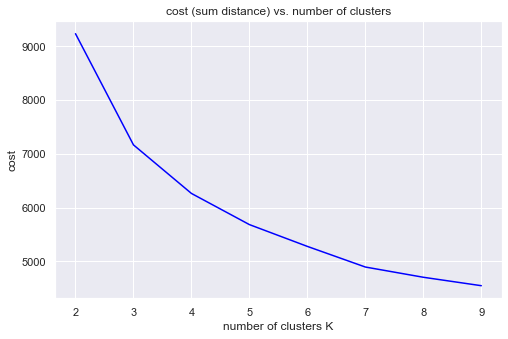

In [221]:

# kprototypes: looking for the elbow - compare number of clusters by their cost
# cost = sum distance of all points to their respective cluster centroids

# run kPrototypes for alternative number of clusters k
dict_cost_c3 = {}
for k in (range(2,10)):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=-1, verbose=2, random_state=42)
    res = kproto.fit_predict(df_cat_num_demo, categorical=[0,1,2])
    dict_cost_c3[k] = kproto.cost_

print("cost (sum distance) for all k:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_cost_c3.items()]


# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(dict_cost_c3.keys(), dict_cost_c3.values(), color="blue")
plt.title("cost (sum distance) vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("cost");

In [222]:
from kneed import KneeLocator
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
cost_knee_c3 = KneeLocator(
        x=list(dict_cost_c3.keys()), 
        y=list(dict_cost_c3.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 4 clusters


In [223]:
# Fit the cluster
kprototype = KPrototypes(n_clusters = 4, init='Cao', n_jobs=-1, verbose=2, random_state=42)
demo_labels=kprototype.fit_predict(df_cat_num_demo, categorical = [0,1,2])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9


In [224]:
# Add the cluster to the dataframe
df_cat_num_demo['Cluster Labels'] = kprototype.labels_
# df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth'})
# df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth', 4: 'Fifth'})
# Order the cluster
df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].astype('category')
# df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third'])
df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third', 'Fourth'])
# df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third', 'Fourth', 'Fifth'])

In [225]:
# Cluster interpretation
df_cat_num_demo.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_cat_num_demo.groupby('Segment').agg(
    {
        'Total':'count',
        'EducDeg': lambda x: x.value_counts().index[0],
        'GeoLivArea': lambda x: x.value_counts().index[0],
        'Children': lambda x: x.value_counts().index[0],
        'Age': 'mean',
    }
).reset_index()

,Segment,Total,EducDeg,GeoLivArea,Children,Age
0,First,2578,b'3 - BSc/MSc',4,1,0.399787
1,Second,1935,b'2 - High School',1,1,-0.309247
2,Third,2331,b'3 - BSc/MSc',4,0,1.288994
3,Fourth,2904,b'3 - BSc/MSc',4,1,-1.162078


In [226]:
df_cat_num_demo

,EducDeg,GeoLivArea,Children,Age,Total,Segment
CustID,,,,,,
1,b'2 - High School',1,1,-0.869107,1,Second
3,b'1 - Basic',3,0,-0.159774,1,Second
4,b'3 - BSc/MSc',4,1,-0.809996,3,Fourth
5,b'3 - BSc/MSc',4,1,-0.337107,0,First
6,b'2 - High School',4,1,0.667782,0,First
...,...,...,...,...,...,...
10291,b'1 - Basic',3,1,-1.873997,3,Fourth
10292,b'4 - PhD',2,0,1.081560,2,Third
10294,b'3 - BSc/MSc',1,1,-0.514441,1,Second


In [227]:
## VER SE EM CATEGORICAS SE USA ESTA MÉTRIC

# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_cat_num_demo)  # get total sum of squares
ssw_labels = df_cat_num_demo.groupby(by='Segment').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

C:\Users\henri\AppData\Local\Temp\ipykernel_1860\48353352.py:5: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ss = np.sum(df.var() * (df.count() - 1))
C:\Users\henri\AppData\Local\Temp\ipykernel_1860\48353352.py:5: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ss = np.sum(df.var() * (df.count() - 1))
C:\Users\henri\AppData\Local\Temp\ipykernel_1860\48353352.py:5: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' 

0.5998885165733157

### K prototypes 4 clusters 
---

### Para insurance

In [228]:
# from sklearn.mixture import GaussianMixture
# # Performing GMM clustering
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
# gmm_labels = gmm.fit_predict(df_insurance)
# labels_proba = gmm.predict_proba(df_insurance)

In [229]:
# # The estimated covariance matrices of the Components
# gmm.covariances_.shape

In [230]:
# # Selecting number of components based on AIC and BIC
# n_components = np.arange(1, 16)
# models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_insurance)
#           for n in n_components]

# bic_values = [m.bic(df_insurance) for m in models]
# aic_values = [m.aic(df_insurance) for m in models]
# plt.plot(n_components, bic_values, label='BIC')
# plt.plot(n_components, aic_values, label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components')
# plt.xticks(n_components)
# plt.show()

In [231]:
# # Performing GMM clustering
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=42)
# gmm_labels = gmm.fit_predict(df_insurance)

In [232]:
# # Concatenating the labels to df
# df_concat = pd.concat([df_insurance, pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
# df_concat.head()

In [233]:
# # Computing the R^2 of the cluster solution
# sst = get_ss(df_insurance)  # get total sum of squares
# ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
# ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
# r2 = ssb / sst
# print("Cluster solution with R^2 of %0.4f" % r2)

Gaussian has a R^2 of 0.4670


In [234]:
df_insurance

,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,
1,-0.887115,0.520969,-0.523131,-0.307112,0.355398,-0.454423
3,-1.224609,-0.757687,0.134203,-0.599335,1.508749,1.210930
4,0.953757,-0.936036,-0.686727,1.904143,0.013263,-0.222251
5,0.677626,0.240449,-0.666561,0.178985,-0.472235,0.043581
6,0.984438,1.009978,-0.797529,-0.730553,-0.817596,-0.641377
...,...,...,...,...,...,...
10291,0.524220,-2.259073,3.097980,-0.887129,2.290648,3.284053
10292,0.861714,0.655767,-0.659084,0.061184,-0.736093,-0.497207
10294,-1.439377,0.730286,-0.281361,-0.362256,-0.651366,-0.697747


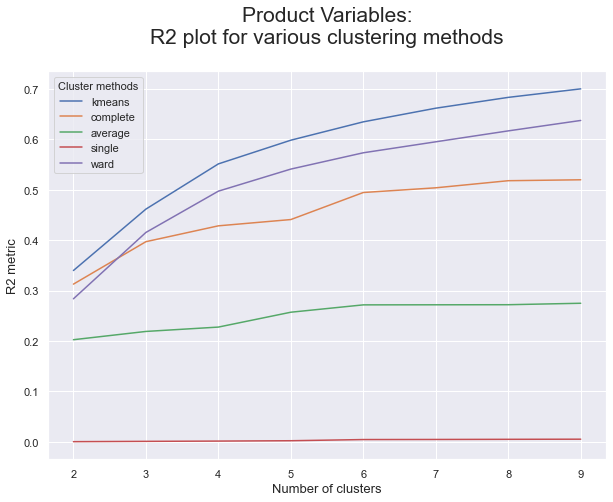

In [235]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust
    
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_insurance, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_insurance, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

silhouette scores:
2 : 0.301
3 : 0.257
4 : 0.283
5 : 0.279
6 : 0.264
7 : 0.248
8 : 0.250
9 : 0.252
maximum silhouette score for 2 clusters:  0.301


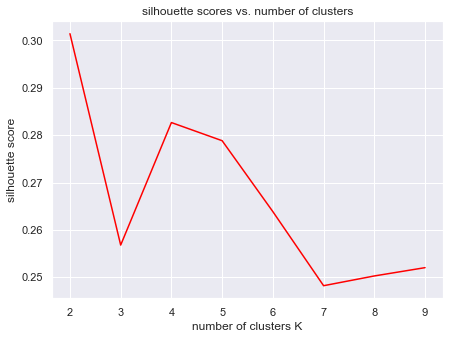

In [236]:
from sklearn.metrics import silhouette_score
# find maximum silhouette score for up to 10 clusters
sil_scores = [silhouette_score(
                                df_insurance, 
                                KMeans(init='k-means++',n_clusters=k, random_state=42, n_init=20). \
                                fit_predict(df_insurance)) \
                                for k in (range(2,10))]

dict_sil = dict(zip(range(2,10), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_b3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_b3 = dict_sil[K_sil_b3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_b3:.0f} clusters: ', f'{sil_opt_b3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,10), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

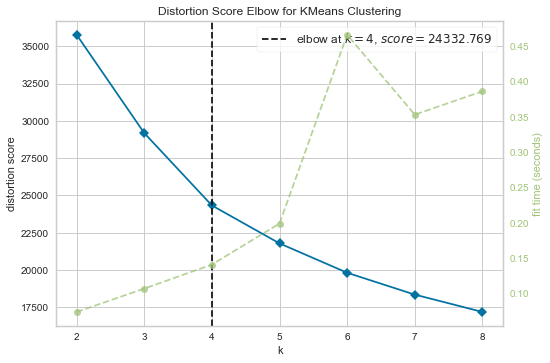

In [237]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init=20, random_state=42), k=(2,9),ax=ax)
visualizer.fit(df_insurance)

ax.set_xticks(range(2,9))
visualizer.show()
plt.show()

### Choose k-means 4 clusters - R^2 ~ 0.55

---

Merging

In [238]:
demo_labels

array([1, 1, 3, ..., 1, 1, 1], dtype=uint16)

In [240]:
df_cat_num

,FirstPolYear,EducDeg,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age
CustID,,,,,,,,,,,
1,-0.155325,b'2 - High School',1,1,-0.887115,0.520969,-0.523131,-0.307112,0.355398,-0.454423,-0.869107
3,0.755415,b'1 - Basic',3,0,-1.224609,-0.757687,0.134203,-0.599335,1.508749,1.210930,-0.159774
4,0.603625,b'3 - BSc/MSc',4,1,0.953757,-0.936036,-0.686727,1.904143,0.013263,-0.222251,-0.809996
5,-0.003535,b'3 - BSc/MSc',4,1,0.677626,0.240449,-0.666561,0.178985,-0.472235,0.043581,-0.337107
6,-0.003535,b'2 - High School',4,1,0.984438,1.009978,-0.797529,-0.730553,-0.817596,-0.641377,0.667782
...,...,...,...,...,...,...,...,...,...,...,...
10291,1.210785,b'1 - Basic',3,1,0.524220,-2.259073,3.097980,-0.887129,2.290648,3.284053,-1.873997
10292,-0.307115,b'4 - PhD',2,0,0.861714,0.655767,-0.659084,0.061184,-0.736093,-0.497207,1.081560
10294,1.210785,b'3 - BSc/MSc',1,1,-1.439377,0.730286,-0.281361,-0.362256,-0.651366,-0.697747,-0.514441


In [241]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_insurance = KMeans(init='k-means++', n_init=20, random_state=42, n_clusters=4)
insurance_labels = kmeans_insurance.fit_predict(df_insurance)



df_cat_num['insurance_labels'] = insurance_labels
df_cat_num['demo_labels'] = demo_labels
df=df_cat_num.copy()

In [242]:
# Count label frequencies (contigency table)
df.groupby(['insurance_labels', 'demo_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('demo_labels', 'insurance_labels', 0)

C:\Users\henri\AppData\Local\Temp\ipykernel_1860\2103856935.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df.groupby(['insurance_labels', 'demo_labels'])\


insurance_labels,0,1,2,3
demo_labels,,,,
0,929,456,960,233
1,591,518,612,214
2,334,1300,326,371
3,470,1113,403,918


merging small clusters using hierarchical

In [243]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['demo_labels', 'insurance_labels'])\
    [metric_features].mean()
df_centroids

ClaimsRate  PremMotor  PremHousehold  \
demo_labels insurance_labels                                         
0           0                  -1.273157   0.980917      -0.499704   
            1                   0.185852  -0.321559      -0.012401   
            2                   0.900097   1.033303      -0.540568   
            3                  -0.122192  -0.725562       1.049922   
1           0                  -1.214745   0.924645      -0.550648   
            1                   0.232097  -0.444676      -0.097455   
            2                   0.922525   0.967080      -0.573951   
            3                   0.088518  -0.861027       1.188178   
2           0                  -1.063762   0.571359      -0.452073   
            1                   0.224654  -0.597965      -0.052971   
            2                   0.885995   0.683023      -0.520000   
            3                  -0.089487  -1.115874       1.193589   
3           0                  -1.133740   0.654264      -0.466779   
            1                   0.205720  -0.616011      -0.032329   
            2                   0.914549   0.753422      -0.569118   
            3                  -0.019619  -1.443687       1.636055   

                              PremHealth  PremLife  PremWork       Age  
demo_labels insurance_labels                                            
0           0                  -0.889339 -0.566173 -0.465050  0.342194  
            1                   0.463186  0.158572  0.074784  0.551245  
            2                  -0.920788 -0.614075 -0.487320  0.344456  
            3                  -0.326042  1.211630  0.708172  0.560976  
1           0                  -0.759110 -0.579469 -0.465087 -0.216084  
            1                   0.756513  0.133331  0.038955 -0.474387  
            2                  -0.800438 -0.603211 -0.489991 -0.222459  
            3                  -0.204619  1.223450  0.714042 -0.415001  
2           0                  -0.281342 -0.462023 -0.394849  1.270220  
            1                   1.074849  0.072232 -0.031570  1.308274  
            2                  -0.392446 -0.528920 -0.441703  1.274306  
            3                   0.270668  1.189858  0.726063  1.251246  
3           0                  -0.358755 -0.527316 -0.448139 -0.891494  
            1                   1.064021  0.053139  0.041528 -1.129611  
            2                  -0.412219 -0.609237 -0.481155 -0.852826  
            3                   0.101839  1.429755  1.297355 -1.475737

In [244]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

c:\Users\henri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


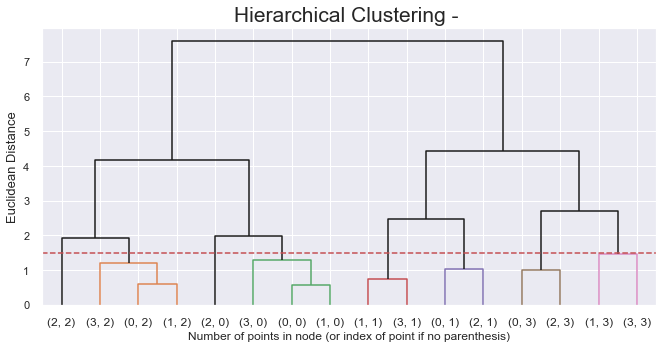

In [246]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.5
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - ', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [247]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=8
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

c:\Users\henri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


ClaimsRate  PremMotor  PremHousehold  \
demo_labels insurance_labels                                         
0           0                  -1.273157   0.980917      -0.499704   
            1                   0.185852  -0.321559      -0.012401   
            2                   0.900097   1.033303      -0.540568   
            3                  -0.122192  -0.725562       1.049922   
1           0                  -1.214745   0.924645      -0.550648   
            1                   0.232097  -0.444676      -0.097455   
            2                   0.922525   0.967080      -0.573951   
            3                   0.088518  -0.861027       1.188178   
2           0                  -1.063762   0.571359      -0.452073   
            1                   0.224654  -0.597965      -0.052971   
            2                   0.885995   0.683023      -0.520000   
            3                  -0.089487  -1.115874       1.193589   
3           0                  -1.133740   0.654264      -0.466779   
            1                   0.205720  -0.616011      -0.032329   
            2                   0.914549   0.753422      -0.569118   
            3                  -0.019619  -1.443687       1.636055   

                              PremHealth  PremLife  PremWork       Age  \
demo_labels insurance_labels                                             
0           0                  -0.889339 -0.566173 -0.465050  0.342194   
            1                   0.463186  0.158572  0.074784  0.551245   
            2                  -0.920788 -0.614075 -0.487320  0.344456   
            3                  -0.326042  1.211630  0.708172  0.560976   
1           0                  -0.759110 -0.579469 -0.465087 -0.216084   
            1                   0.756513  0.133331  0.038955 -0.474387   
            2                  -0.800438 -0.603211 -0.489991 -0.222459   
            3                  -0.204619  1.223450  0.714042 -0.415001   
2           0                  -0.281342 -0.462023 -0.394849  1.270220   
            1                   1.074849  0.072232 -0.031570  1.308274   
            2                  -0.392446 -0.528920 -0.441703  1.274306   
            3                   0.270668  1.189858  0.726063  1.251246   
3           0                  -0.358755 -0.527316 -0.448139 -0.891494   
            1                   1.064021  0.053139  0.041528 -1.129611   
            2                  -0.412219 -0.609237 -0.481155 -0.852826   
            3                   0.101839  1.429755  1.297355 -1.475737   

                              hclust_labels  
demo_labels insurance_labels                 
0           0                             1  
            1                             3  
            2                             2  
            3                             4  
1           0                             1  
            1                             5  
            2                             2  
            3                             0  
2           0                             6  
            1                             3  
            2                             7  
            3                             4  
3           0                             1  
            1                             5  
            2                             2  
            3                             0

In [248]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['demo_labels'], row['insurance_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

C:\Users\henri\AppData\Local\Temp\ipykernel_1860\379347144.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_.groupby('merged_labels').mean()[metric_features]


,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age
merged_labels,,,,,,,
0,0.000824,-1.333537,1.551386,0.043905,1.390754,1.187082,-1.275209
1,-1.222882,0.887056,-0.507057,-0.725349,-0.560944,-0.461067,-0.114980
2,0.909996,0.955672,-0.556738,-0.779721,-0.609721,-0.486889,-0.075522
3,0.214578,-0.526187,-0.042436,0.916012,0.094653,-0.003952,1.111688
4,-0.102103,-0.965306,1.138168,0.040480,1.198257,0.719161,0.984966
5,0.214097,-0.561595,-0.053013,0.966357,0.078608,0.040711,-0.921514
6,-1.063762,0.571359,-0.452073,-0.281342,-0.462023,-0.394849,1.270220
7,0.885995,0.683023,-0.520000,-0.392446,-0.528920,-0.441703,1.274306


In [249]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['demo_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['insurance_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('demo_labels', 'insurance_labels', 0)

C:\Users\henri\AppData\Local\Temp\ipykernel_1860\1369238836.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_counts.pivot('demo_labels', 'insurance_labels', 0)


insurance_labels,0,1,2,3
demo_labels,,,,
2,334,1756,326,604
3,1990,1631,1975,1132


In [250]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

In [251]:
df

,FirstPolYear,EducDeg,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,insurance_labels,demo_labels,merged_labels
CustID,,,,,,,,,,,,,,
1,-0.155325,b'2 - High School',1,1,-0.887115,0.520969,-0.523131,-0.307112,0.355398,-0.454423,-0.869107,0,1,1
3,0.755415,b'1 - Basic',3,0,-1.224609,-0.757687,0.134203,-0.599335,1.508749,1.210930,-0.159774,3,1,0
4,0.603625,b'3 - BSc/MSc',4,1,0.953757,-0.936036,-0.686727,1.904143,0.013263,-0.222251,-0.809996,1,3,5
5,-0.003535,b'3 - BSc/MSc',4,1,0.677626,0.240449,-0.666561,0.178985,-0.472235,0.043581,-0.337107,2,0,2
6,-0.003535,b'2 - High School',4,1,0.984438,1.009978,-0.797529,-0.730553,-0.817596,-0.641377,0.667782,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,1.210785,b'1 - Basic',3,1,0.524220,-2.259073,3.097980,-0.887129,2.290648,3.284053,-1.873997,3,3,0
10292,-0.307115,b'4 - PhD',2,0,0.861714,0.655767,-0.659084,0.061184,-0.736093,-0.497207,1.081560,2,2,7
10294,1.210785,b'3 - BSc/MSc',1,1,-1.439377,0.730286,-0.281361,-0.362256,-0.651366,-0.697747,-0.514441,0,1,1


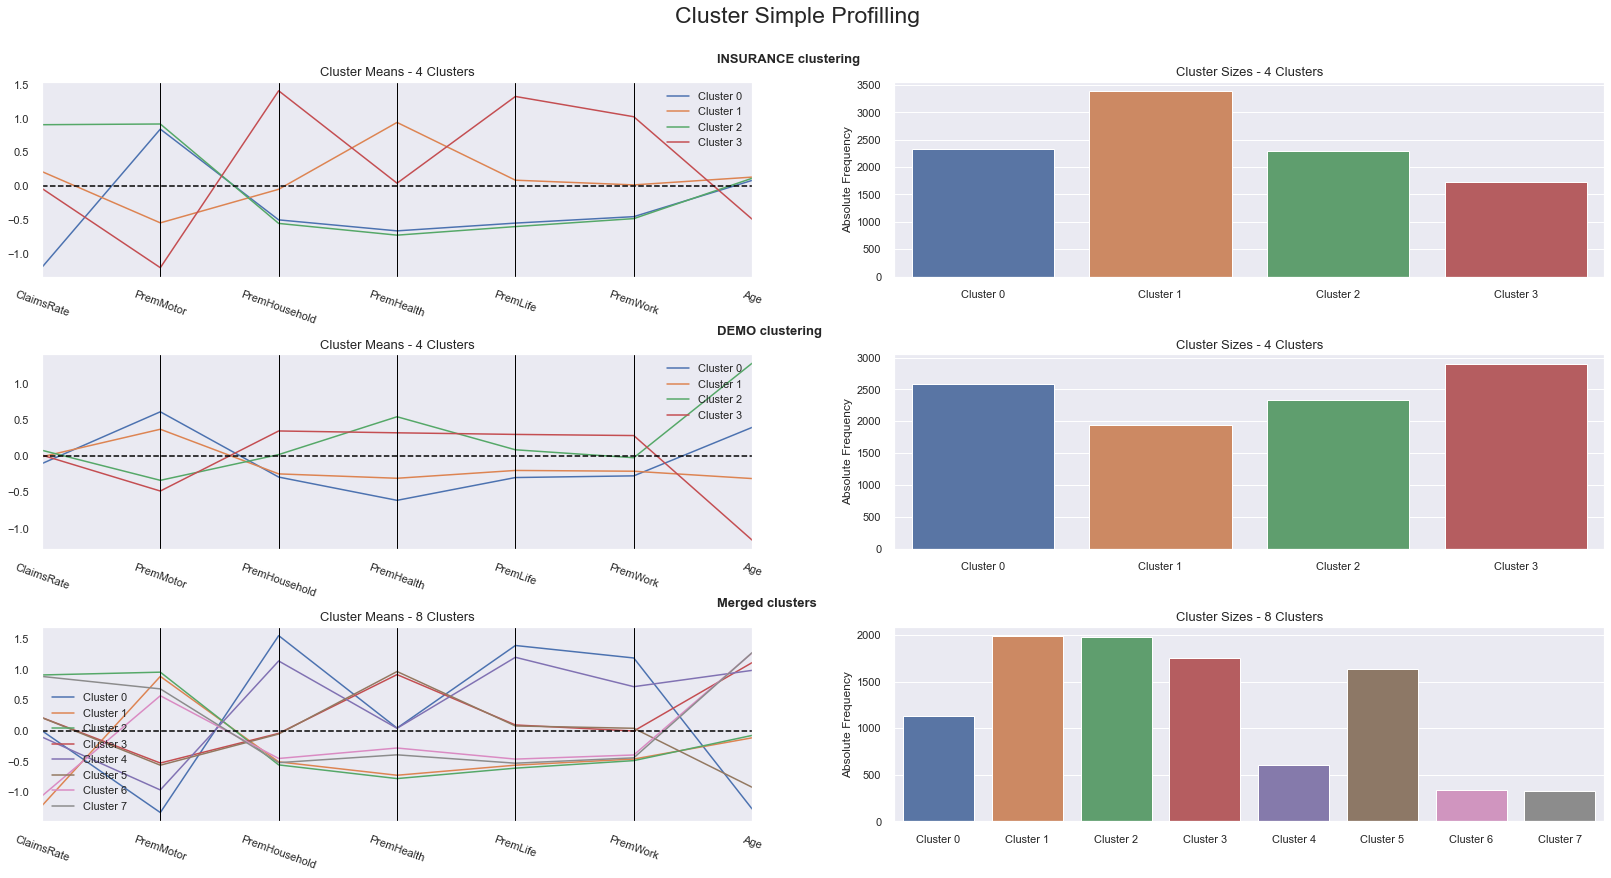

In [252]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['insurance_labels', 'demo_labels', 'merged_labels']], 
    label_columns = ['insurance_labels', 'demo_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["INSURANCE clustering", "DEMO clustering", "Merged clusters"]
)

In [272]:
# Characterizing the final clusters
df_means = df.groupby('merged_labels').mean().copy()
df_means= df_means[metric_features]
df_means

C:\Users\henri\AppData\Local\Temp\ipykernel_1860\405036661.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means = df.groupby('merged_labels').mean().copy()


,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age
merged_labels,,,,,,,
0,0.000824,-1.333537,1.551386,0.043905,1.390754,1.187082,-1.275209
1,-1.222882,0.887056,-0.507057,-0.725349,-0.560944,-0.461067,-0.114980
2,0.909996,0.955672,-0.556738,-0.779721,-0.609721,-0.486889,-0.075522
3,0.214578,-0.526187,-0.042436,0.916012,0.094653,-0.003952,1.111688
4,-0.102103,-0.965306,1.138168,0.040480,1.198257,0.719161,0.984966
5,0.214097,-0.561595,-0.053013,0.966357,0.078608,0.040711,-0.921514
6,-1.063762,0.571359,-0.452073,-0.281342,-0.462023,-0.394849,1.270220
7,0.885995,0.683023,-0.520000,-0.392446,-0.528920,-0.441703,1.274306


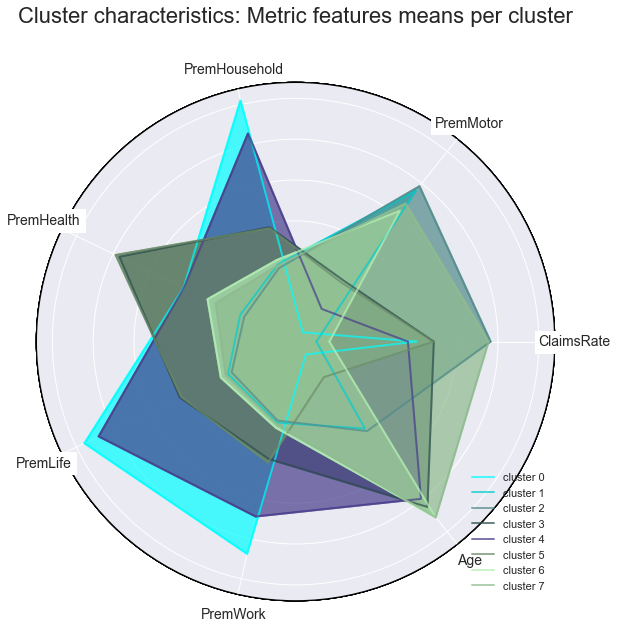

In [281]:
cluster_colors = ['#00FFFF', '#00CED1', '#528B8B', '#2F4F4F', '#483D8B', '#698B69', '#B4EEB4', '#8FBC8F']

class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

fig = plt.figure(figsize=(8, 8))
no_features = len(metric_features)
radar = Radar(fig, metric_features, np.unique(df['merged_labels']))

for k in range(0,len(np.unique(df['merged_labels']))):
    cluster_data = df_means.T[k].values.tolist()
    radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Metric features means per cluster", size=22, pad=60)
plt.show()

In [311]:
# helper function: pie charts for categorical variables
def cluster_pies(df):
    
    # number of categorical variables
    c = 3
    
    # number of clusters
    K = df["merged_labels"].nunique()

    for k in (range(K)):
        dfc = df[df["merged_labels"]==k]
        # chrg = dfc["MonthlyCharges"].median()
        # ten = dfc["tenure"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(50, 12))
        fig.suptitle("Cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases")


        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["EducDeg"].value_counts(), labels=dfc["EducDeg"].unique(), autopct='%1.1f%%')
        plt.title("EducDeg");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["Children"].value_counts(), labels=dfc["Children"].unique(), autopct='%1.1f%%')
        plt.title("Children");

        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["GeoLivArea"].value_counts(), labels=dfc["GeoLivArea"].unique(), autopct='%1.1f%%')
        plt.title("GeoLivArea");

        # ax1 = plt.subplot2grid((2,c),(0,3))
        # plt.hist(dfc["Age"])
        # plt.title("Age");

        # ax1 = plt.subplot2grid((2,c),(0,4))
        # plt.pie(dfc["PhoneService"].value_counts(), labels=dfc["PhoneService"].unique())
        # plt.title("PhoneService");

        # ax1 = plt.subplot2grid((2,c),(0,5))
        # plt.pie(dfc["InternetService"].value_counts(), labels=dfc["InternetService"].unique())
        # plt.title("InternetService");

        # ax1 = plt.subplot2grid((2,c),(0,6))
        # plt.pie(dfc["StreamingTV"].value_counts(), labels=dfc["StreamingTV"].unique())
        # plt.title("StreamingTV");

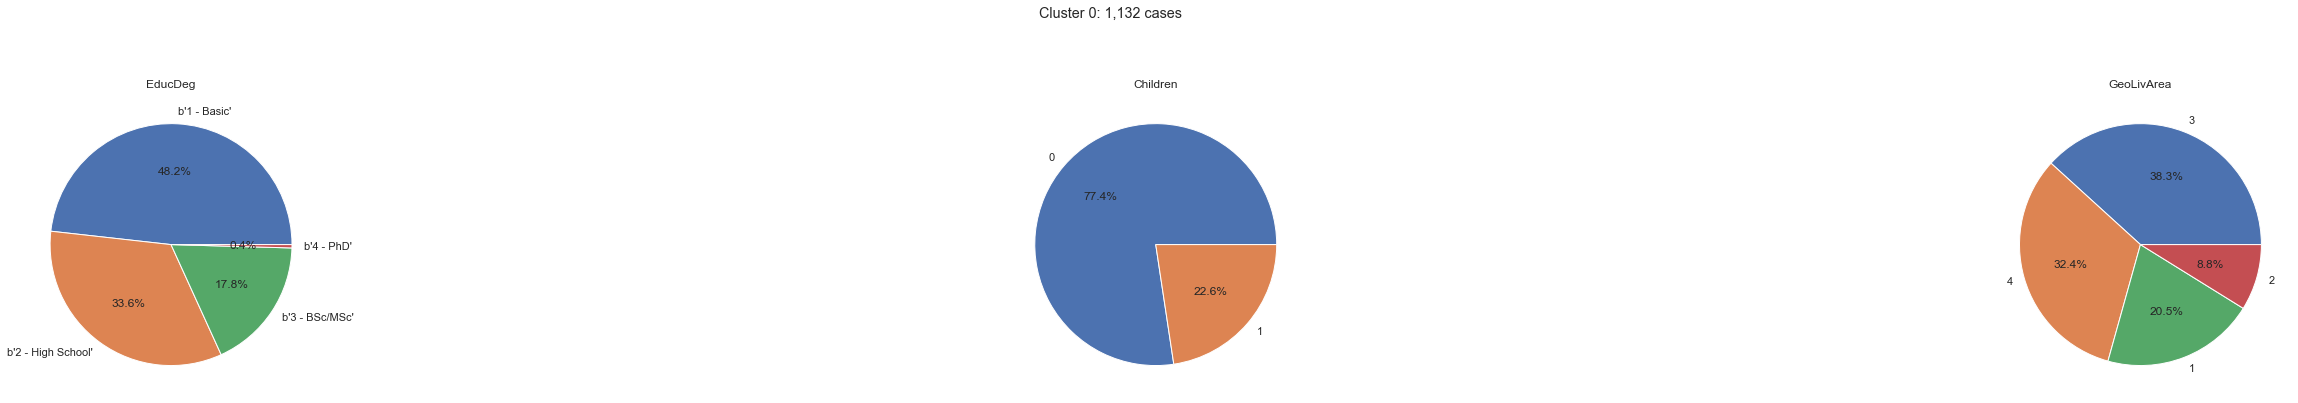

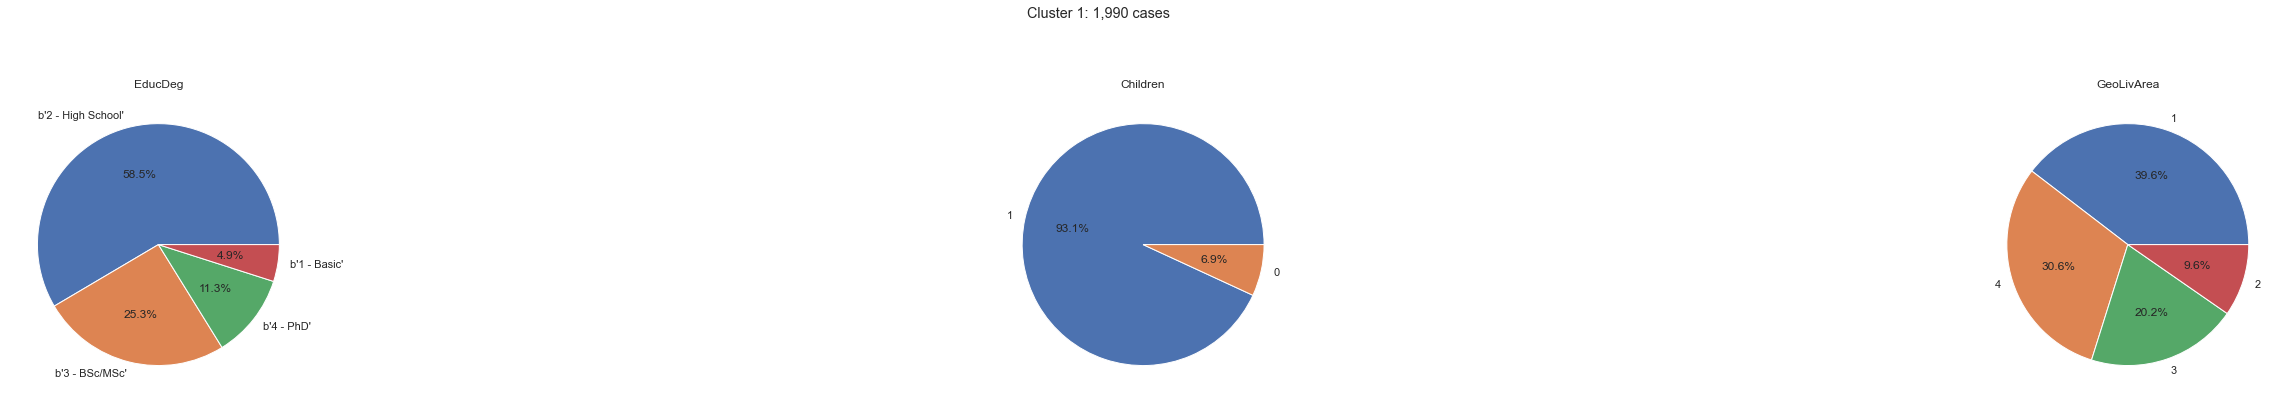

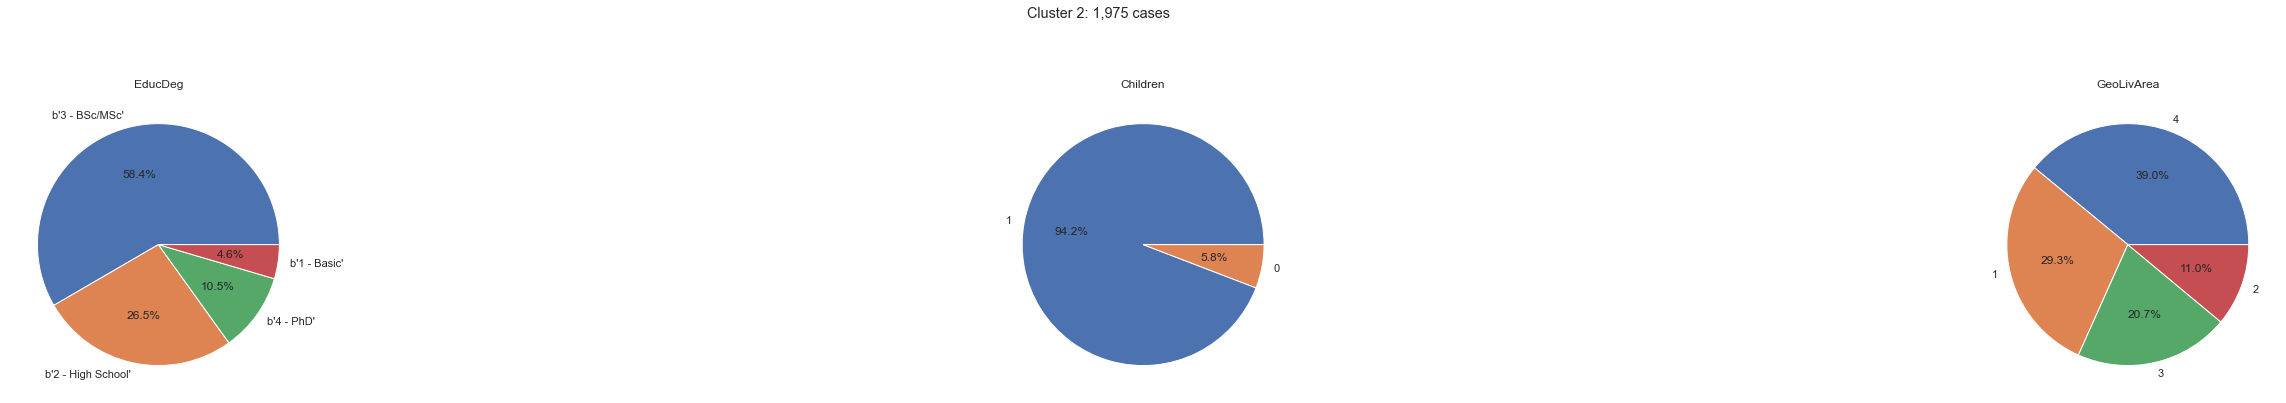

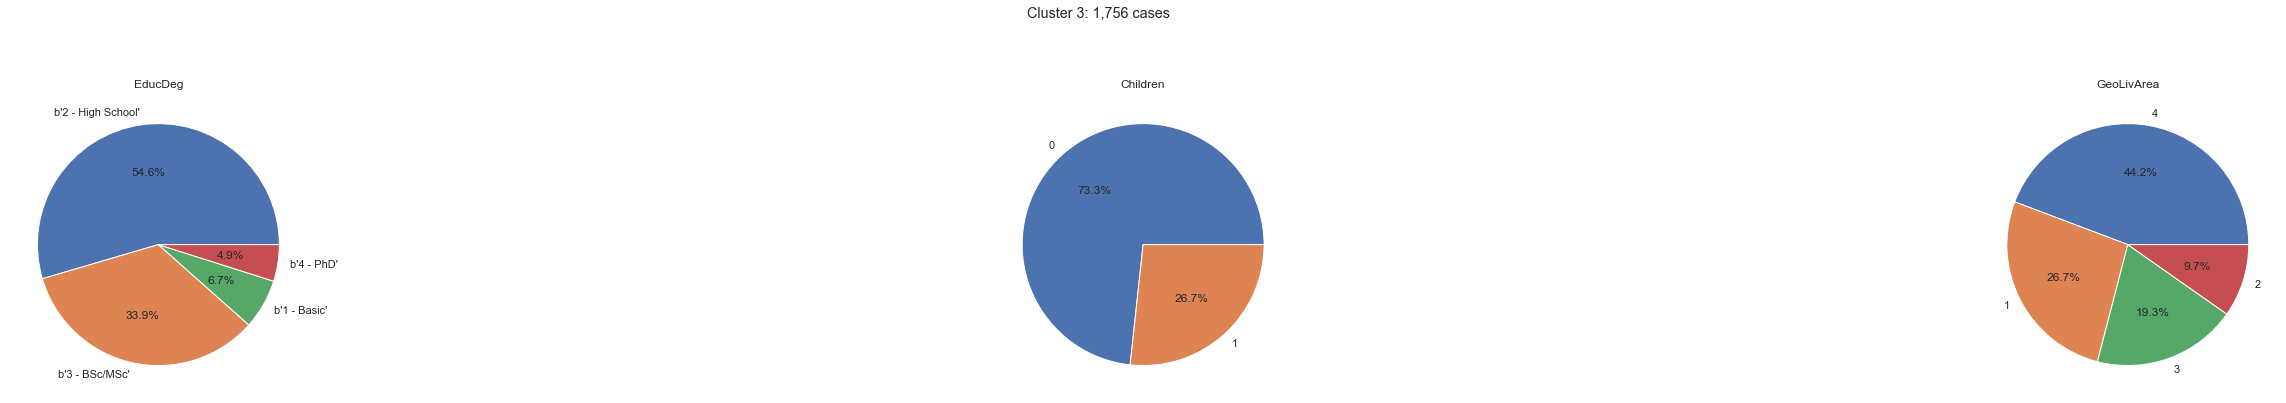

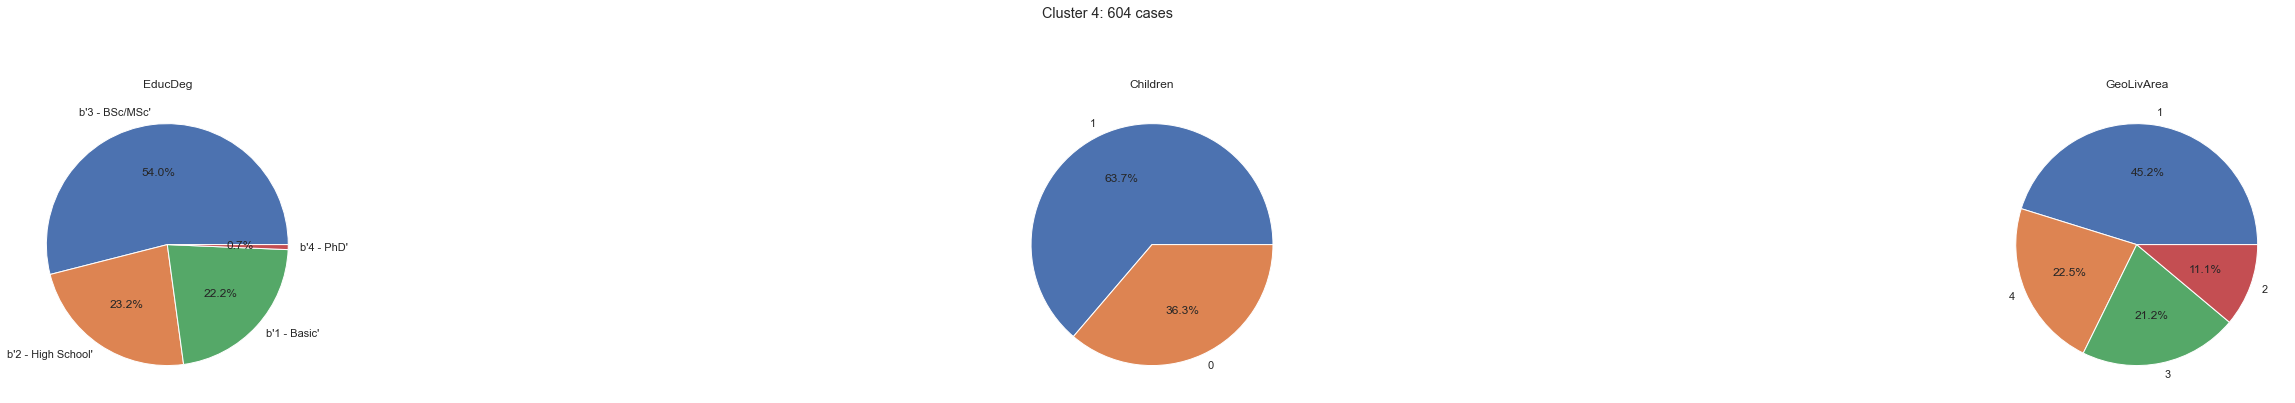

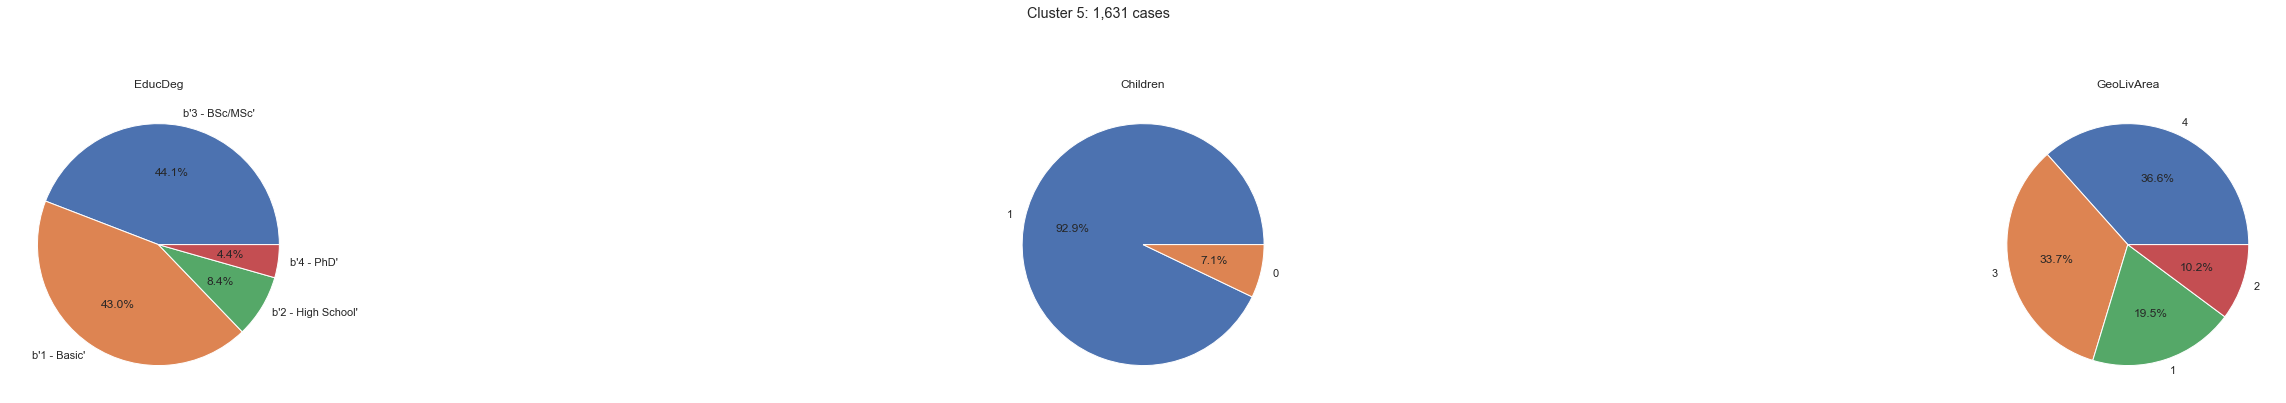

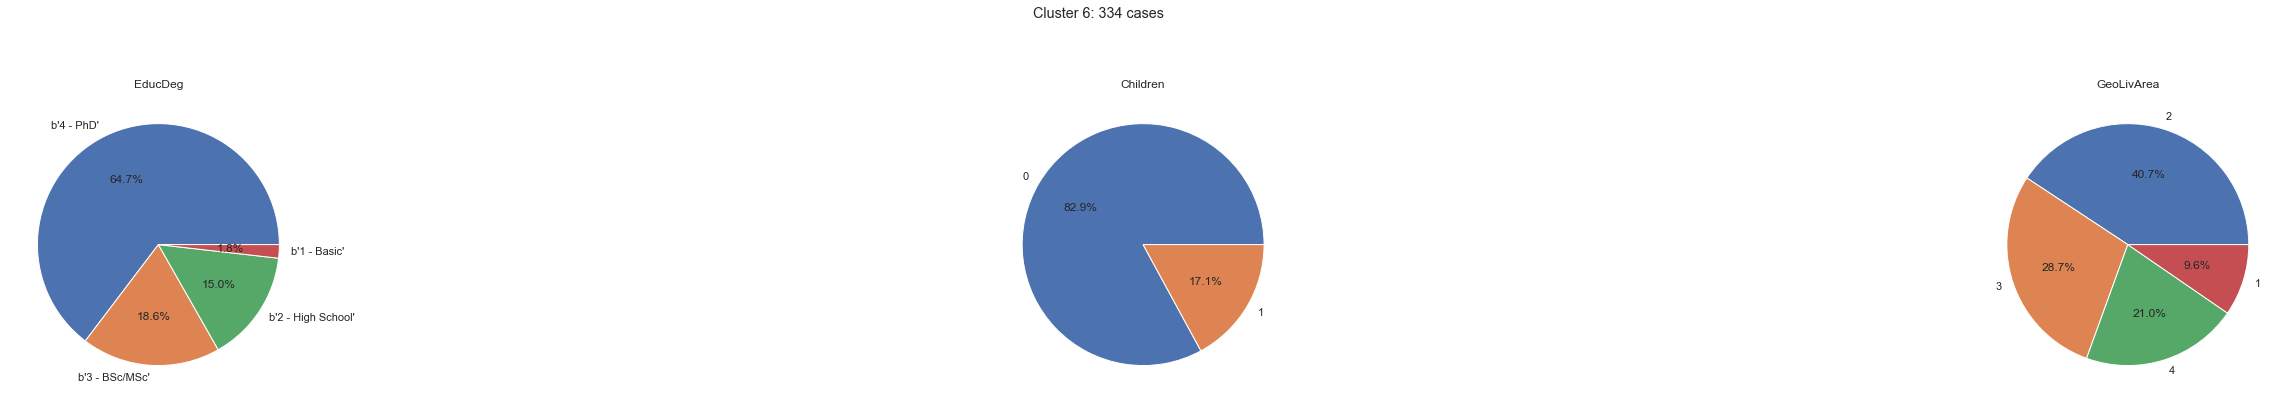

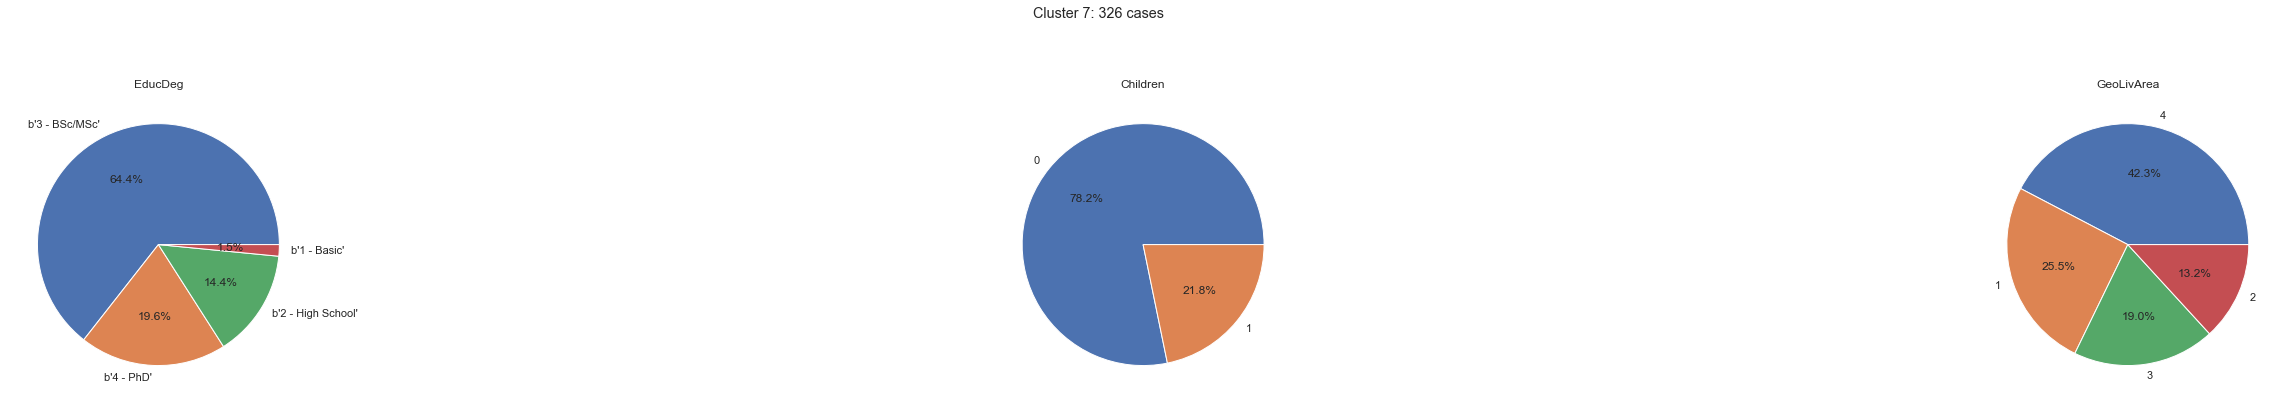

In [312]:
cluster_pies(df)

In [313]:
from sklearn.manifold import TSNE
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

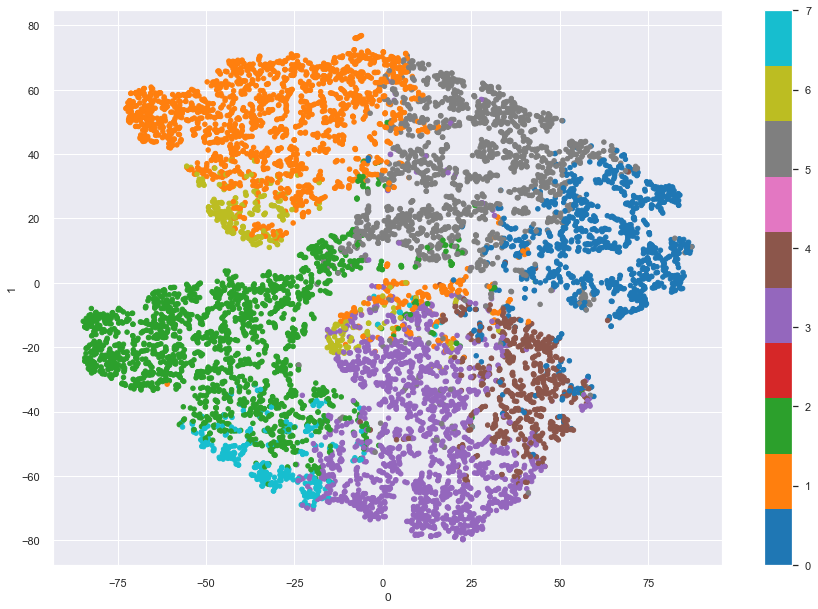

In [314]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

In [321]:
from umap import UMAP

# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )

# Fit and transform the data
X_trans = reducer.fit_transform(df[metric_features])

# Check the shape of the new data
print('Shape of X_trans: ', X_trans.shape)

ImportError: cannot import name 'UMAP' from 'umap' (c:\Users\henri\anaconda3\lib\site-packages\umap\__init__.py)

---

### - no kmeans, fazer um com pca e outro com as variaveis normais
### - DBSCAN
### - plots no PCA?
### - Standart scaler está a acrescentar 16 NaN
### - A caracterização dos clusters continua a ter valores demasiado próximos (HC e kmeans)... perguntar a prof?
---
#### --- Usei Robust Scaler, mas no hierarchical está a criar um cluster com 3 elementos
### - K-prototypes
### - Criar 2 tipos de clusters antes do SOMs
### - Fazer t_SNE / UMAP
### - Colocar imports todos no inicio
### - Apesar de nao se usar as categoricas na criacao de clusters, é importante no final mostrar a sua distribuicao dentro do cluster
### - FirstPolYear nao devia ser a idade com que se fez o primeiro seguro. E pode entrar nas demograficas
### - Retirar outliers obvios, fill missing, remover outliers (DBSCAN, ou os outros tmb)
### - SOMS é data exploration para retirar alguma variavel, e pode ser usado depois em clustering